# Authors for this notebook:
- Thomas D. Robertson II
- Sharon Colson
- Tania Perdomo-Flores
- Caleb Smith

# 🌪️ Natural Disaster Tweet Classification Project

This notebook explores and models tweet data to classify whether a tweet is about a real disaster or not. We'll clean and preprocess the data in several ways, visualize it, generate multiple datasets, and run various NLP models to compare performance.

---

## 📌 Table of Contents
1. [Import Data](#import-data)
2. [Initial Data Cleaning](#initial-data-cleaning)
   - Detect Non-ASCII Characters
   - Apply Replacement for Known Corrupted Sequences
   - Normalize Remaining Unicode Characters
   - Data Preprocessing
      - Drop Unnecessary Columns
      - Handle Missing Values
      - Remove Conflicting Labels
      - Remove Duplicates
   - Save Cleaned Data Sets
3. [Exploratory Data Analysis (EDA)](#eda)
   - Dataset Overview
      - Dataset Shape
      - Column Data Types
      - Unique Value Counts per Column
      - Basic Text Length Statistics
   - Target distribution
      - Count and Proportion of Target Class
      - Bar Chart and Target Frequencies
      - Brief Comment on Class Balance
   - Tweet Length Analysis
      - Histogram of tweet lengths
      - Length distribution per class (0 vs. 1)
      - Boxplots
      - Sample of longest tweets
   - Mention (@) Analysis
      - Frequency of @mentions by class
      - Top mentions visualized
      - Comments on usage trends
   - URL Analysis
      - Frequency and examples of URLs
      - Distribution by target class
      - Bar chart of top URLs
   - Detect Rows with Emojis or ASCII Emoticons
      - Detect and count emojis
      - Analyze distribution by class
      - Visualize presence of common special characters (e.g., ‘!’, ‘#’, ‘:’, etc.)
   - Sample Tweet Inspection
      - Display example tweets by class
      - Include edge cases (very short, very long, only special characters, etc.)
4. [Text Preprocessing Variants](#preprocessing-variants)
   - Define Preprocessing Variants
     - Basic Cleaning
     - Remove Emojis and Mentions
     - Lemmatization
     - Stemming
     - Lemmatization + Stemming
     - Lemmatization + Custom Stopwords
     - Lowercase Alphabetic Tokens Only
     - Lemmatization + Keep Hashtags
     - Minimal Processing
     - Lemmatization + Stemming + Custom Stopwords
   - Save Final Processed Datasets
5. [Word Clouds & Comparison](#wordclouds)
6. [Baseline Modeling Pipeline](#baseline-modeling)
   - Load Preprocessed Datasets
   - Define Baseline Classifier Pipelines
   - Apply TF-IDF Vectorization
   - Train/Test Split (80/20)
   - Train Baseline Models:
     - Multinomial Naive Bayes
     - Logistic Regression
     - Passive Aggressive Classifier
     - Support Vector Machine
     - K-Nearest Neighbors
     - Neural Network (MLP)
   - Evaluate Models (Cross-Validation + Test Set)
   - Save Performance Metrics
7. [Hyperparameter Tuning](#hyperparameter-tuning)
   - Define GridSearchCV Search Spaces
   - Run Hypertuning on Selected Models
   - Evaluate Best-Tuned Models
   - Save Best Model Summaries
   - Save Tuned Performance Metrics

8. [Pre-Trained Models: BERT and BERTweet](#bert)

9. [Performance Aggregation and Visualization](#performance-comparison)
   - Merge All Result Files
   - Load Aggregated Results
   - Top Model per Algorithm: Baseline vs Tuned Comparison
   - Visualize F1 Score Comparison per Model
   - Greatest F1 Improvement Per Model
   - Visualize the Greatest F1 Improvement
   - Top Model per Dataset: Baseline vs Tuned Comparison
   - Visualize F1 Score Comparison per Dataset
   - Best Hyper-Tuned Model Hyperparameters
   - Visualize Best Model Performance

10. [Research Paper](#conclusion)

---
## 1. 📥 Import Data <a name="import-data"></a>
---

In [ ]:
# ⚠️ Warning Handling
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# 📦 Core Dependencies
import chardet
import numpy as np
import os
import pandas as pd
import re
import string
import sys
from collections import Counter
from IPython.display import Image, display
from unidecode import unidecode

# 📊 Data Visualization
import matplotlib.pyplot as plt
from matplotlib import cm  # for colormap
from matplotlib.colors import to_hex
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud
# For inline plotting in Jupyter
%matplotlib inline

# 🧠 Natural Language Processing (NLTK)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# ⚙️ Machine Learning - Models & Evaluation
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, cross_validate, learning_curve, train_test_split, GridSearchCV
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# 🔢 Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 🤗 For Running BERT and BERTweet
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import KFold
import torch

In [ ]:
# nltk downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
# Spacy
# !python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_md")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sharon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sharon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Sharon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sharon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sharon\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# 📥 Load and Inspect Data

# Detect encoding of the training CSV file to avoid character corruption
with open("data/train.csv", "rb") as f:
    raw_data = f.read(100_000)  # Read the first 100KB
    result = chardet.detect(raw_data)
    detected_encoding = result['encoding']

# Fallback in case encoding couldn't be detected
if detected_encoding is None:
    detected_encoding = 'utf-8'

print(f"Detected Encoding: {detected_encoding}")

# Load training and test datasets using the detected encoding
train_data = pd.read_csv("data/train.csv", encoding=detected_encoding)
test_data = pd.read_csv("data/test.csv", encoding=detected_encoding)

# Reset index to ensure consistency
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# 🔍 Preview the first few rows of the training data
train_data.head()


Detected Encoding: utf-8


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


---
## 2. 🧼 Initial Data Cleaning <a name="initial-data-cleaning"></a>
- Fix known corrupted sequences
- Remove duplicates
- Fill or drop null values
- Normalize text (e.g., remove non-ASCII)
---

### 2.1 🔍 Detect Non-ASCII Characters


In [ ]:
def get_corrupted_char_counts(series):
    """
    Count non-ASCII characters in a Pandas Series of text.

    Args:
        series (pd.Series): Column of text to inspect.

    Returns:
        Counter: Dictionary of non-ASCII characters and their frequencies.
    """
    counts = Counter()
    for text in series:
        if isinstance(text, str):
            for char in re.findall(r"[^\x00-\x7F]", text):
                counts[char] += 1
    return counts


In [ ]:

def contains_non_ascii(text):
    """
    Check if a text contains any non-ASCII characters.

    Args:
        text (str): Input text

    Returns:
        bool: True if non-ASCII characters found, False otherwise
    """
    return bool(re.search(r'[^\x00-\x7F]', str(text)))


In [ ]:
# Run corrupted character detection
corrupted_counts = get_corrupted_char_counts(train_data['text'])
print("Top corrupted characters:", corrupted_counts.most_common(10))

# Identify rows containing non-ASCII characters in any object column
df_corrupted = train_data[train_data.select_dtypes(include='object').applymap(contains_non_ascii).any(axis=1)]


Top corrupted characters: [('\x89', 797), ('Û', 794), ('ª', 191), ('å', 96), ('Ï', 69), ('Ê', 66), ('÷', 49), ('Ò', 45), ('\x9d', 44), ('Ó', 33)]


In [ ]:
df_corrupted.head()

,id,keyword,location,text,target
38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1
52,76,ablaze,Barbados,SANTA CRUZ ÛÓ Head of the St Elizabeth Police...,0
53,77,ablaze,Anaheim,Police: Arsonist Deliberately Set Black Church...,1
57,81,ablaze,"Sao Paulo, Brazil",Set our hearts ablaze and every city was a gif...,0
71,102,accident,"St. Louis, MO",#stlouis #caraccidentlawyer Speeding Among Top...,0


### 2.2 🧹 Apply Replacement for Known Corrupted Sequences


In [ ]:
# Replace known misencoded sequences in specified text columns
corrections = {
    "ÛÒ": "-", "\x89ÛÓ": "-", "@\x89Û_": "@_", "\x89Û_": "_",
    "ã¢": "TM", "\x89ÛÏ": '"', "\x89Û\x9d": '"', "\x89Ûª": "'",
    "åÊ": " ", "\x89Û÷": "'", "å£": "£", "# ": "#", "å¤}": "",
    "å_?": "", "åÇ": "...", "åÈ": ".", "ÌÑ1": "#1", "ÌÑ": "x",
    "Ìü": "", "Ì´": "'", "\n\n": " ", "Ì©": "e", "Ì¼": "u",
    "\x89Û¢": '"', "å¡": "!", "&amp;": " ", "å«": "'",
    "\x89âÂ": "", "å¨": "", "å¬": "", "Ì¤": "c", "Ì_n": "an",
    "Ì_": "i", "Nå¼": "number", "å_": "", "é": "e", "ón": "an",
    "ç": "c", "í": "i", "Ì¢": "", "\n": "", "å©": " @", "º": "o",
}

def apply_text_corrections(df, columns, corrections):
    for bad, good in corrections.items():
        for col in columns:
            df[col] = df[col].str.replace(bad, good, regex=False)
    return df


In [ ]:
train_data = apply_text_corrections(train_data, ['text', 'location'], corrections)

### 2.3 🔠 Normalize Remaining Unicode Characters (e.g., Accents)


In [ ]:
def normalize_column_text(df, columns):
    """
    Apply unidecode normalization to specific columns of a dataframe.

    Args:
        df (pd.DataFrame): The input dataframe.
        columns (list): List of text columns to normalize.

    Returns:
        pd.DataFrame: DataFrame with normalized text columns.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: unidecode(str(x)) if isinstance(x, str) else x)
    return df


In [ ]:
# Apply normalization
train_data = normalize_column_text(train_data, ['text', 'location'])

### 2.4 🧹 Data Preprocessing
- 📤 Drop Unnecessary Columns  
    - Remove columns that are not useful for modeling (e.g., `location`, `id`).
- 🕳️ Handle Missing Values  
    - Detect and remove rows containing `NaN` values after dropping unused columns.
- ⚠️ Remove Conflicting Labels  
    - Exclude tweets that appear with the same text but different target labels to reduce noise.
- 📋 Remove Duplicates  
    - Drop duplicate rows based on meaningful features like `text`, `target`, and optionally `keyword`.


In [ ]:
def prepare_dataset(df: pd.DataFrame, keyword_strategy: str = "prepend") -> pd.DataFrame:
    """
    Cleans and deduplicates the tweet dataset with optional keyword handling.

    Steps:
    - Drop 'id' and 'location' columns
    - Drop rows with NaN values after column drops
    - Remove rows with same text but conflicting target labels
    - Drop duplicates based on relevant columns (before modifying 'text')
    - Handle 'keyword' based on the strategy:
        - 'prepend': Prepend keyword to the text and drop the column
        - 'keep': Keep keyword column
        - 'drop': Drop keyword column

    Parameters:
    -----------
    df : pd.DataFrame
        Original DataFrame with columns: id, keyword, location, text, target.

    keyword_strategy : str
        How to handle the 'keyword' column. One of:
            - 'prepend': Prepend keyword to text and drop keyword column
            - 'keep': Keep the keyword column as-is
            - 'drop': Drop the keyword column completely

    Returns:
    --------
    pd.DataFrame
        A cleaned and deduplicated DataFrame ready for modeling.
    """
    assert keyword_strategy in ['prepend', 'keep', 'drop'], "Invalid keyword_strategy. Choose from 'prepend', 'keep', or 'drop'."

    # Drop 'id' and 'location' columns
    df_cleaned = df.drop(columns=['id', 'location'], errors='ignore').copy()

    # Drop any rows with NaN values
    before_nan = len(df_cleaned)
    df_cleaned = df_cleaned.dropna().reset_index(drop=True)
    after_nan = len(df_cleaned)
    print(f"Dropped {before_nan - after_nan} rows with NaN values after dropping unused columns.")

    # Remove rows with same text and different target values (conflicts)
    conflict_texts = (
        df_cleaned.groupby('text')['target']
        .nunique()
        .reset_index()
        .query('target > 1')['text']
    )

    before_conflict = len(df_cleaned)
    df_cleaned = df_cleaned[~df_cleaned['text'].isin(conflict_texts)].reset_index(drop=True)
    after_conflict = len(df_cleaned)
    print(f"Removed {before_conflict - after_conflict} rows with conflicting labels on identical text.")

    # Deduplicate BEFORE keyword modification
    dedup_cols = ['text', 'target']
    if keyword_strategy == 'keep' and 'keyword' in df_cleaned.columns:
        dedup_cols.insert(1, 'keyword')

    before_dupes = len(df_cleaned)
    df_deduped = df_cleaned.drop_duplicates(subset=dedup_cols).reset_index(drop=True)
    after_dupes = len(df_deduped)
    print(f"Dropped {before_dupes - after_dupes} duplicates based on: {dedup_cols}")

    # Handle keyword column after deduplication
    if keyword_strategy == 'prepend' and 'keyword' in df_deduped.columns:
        df_deduped['text'] = df_deduped.apply(
            lambda row: f"{row['keyword']} {row['text']}" if pd.notnull(row['keyword']) else row['text'],
            axis=1
        )
        df_deduped.drop(columns=['keyword'], inplace=True)

    elif keyword_strategy == 'drop' and 'keyword' in df_deduped.columns:
        df_deduped.drop(columns=['keyword'], inplace=True)

    return df_deduped


In [ ]:
# Prepend keyword to text, then drop keyword column
df_keyword_prepended = prepare_dataset(train_data, keyword_strategy="prepend")

# Drop keyword completely
df_keyword_dropped = prepare_dataset(train_data, keyword_strategy="drop")

# Keep keyword as a separate column
df_keyword_kept = prepare_dataset(train_data, keyword_strategy="keep")


Dropped 61 rows with NaN values after dropping unused columns.
Removed 55 rows with conflicting labels on identical text.
Dropped 68 duplicates based on: ['text', 'target']
Dropped 61 rows with NaN values after dropping unused columns.
Removed 55 rows with conflicting labels on identical text.
Dropped 68 duplicates based on: ['text', 'target']
Dropped 61 rows with NaN values after dropping unused columns.
Removed 55 rows with conflicting labels on identical text.
Dropped 53 duplicates based on: ['text', 'keyword', 'target']


### 2.5 💾 Save Cleaned Datasets for Reuse

In [ ]:
# Define output file paths
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save datasets to CSV
df_keyword_prepended.to_csv(f"{output_dir}/train_keyword_prepended.csv", index=False)
df_keyword_dropped.to_csv(f"{output_dir}/train_keyword_dropped.csv", index=False)
df_keyword_kept.to_csv(f"{output_dir}/train_keyword_kept.csv", index=False)

print("✅ All cleaned datasets saved to 'processed_data/' folder.")

✅ All cleaned datasets saved to 'processed_data/' folder.



---

## 3. 📊 Exploratory Data Analysis (EDA) <a name="eda"></a>
- Dataset Overview
- Distribution of target labels (0/1)
- Tweet length histogram
- Hashtag Analysis
- @mention Analysis
- URL Analysis
- Emoji presence
- Sample Tweet Analysis

---

### 3.1 📈 Dataset Overview
- Dataset shape (rows, columns)
- Column data types
- Missing value summary
- Unique value count per column
- Basic text length statistics


In [ ]:
def dataset_overview(df: pd.DataFrame, text_column: str = "text") -> None:
    """
    Displays key statistics and information about the structure of the dataset.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataset to summarize.
    text_column : str, default="text"
        Name of the column containing tweet text for length analysis.
    """

    print("🔍 Dataset Overview")
    print("=" * 40)

    # Shape
    print(f"Shape (rows, columns): {df.shape}")

    # Column data types
    print("\n📦 Data Types:")
    print(df.dtypes)

    # Null values
    print("\n🕳️ Missing Values per Column:")
    print(df.isnull().sum())

    # Unique values
    print("\n🔢 Unique Values per Column:")
    print(df.nunique())

    # Text length stats
    if text_column in df.columns:
        df['text_length'] = df[text_column].apply(len)
        print("\n✏️ Text Length Statistics:")
        print(df['text_length'].describe())
    else:
        print(f"\n⚠️ Text column '{text_column}' not found in DataFrame.")

    print("=" * 40)


In [ ]:
dataset_overview(df_keyword_prepended)
dataset_overview(df_keyword_dropped)
dataset_overview(df_keyword_kept)


🔍 Dataset Overview
Shape (rows, columns): (7429, 2)

📦 Data Types:
text      object
target     int64
dtype: object

🕳️ Missing Values per Column:
text      0
target    0
dtype: int64

🔢 Unique Values per Column:
text      7429
target       2
dtype: int64

✏️ Text Length Statistics:
count    7429.000000
mean      110.319828
std        33.964801
min        15.000000
25%        86.000000
50%       116.000000
75%       142.000000
max       164.000000
Name: text_length, dtype: float64
🔍 Dataset Overview
Shape (rows, columns): (7429, 2)

📦 Data Types:
text      object
target     int64
dtype: object

🕳️ Missing Values per Column:
text      0
target    0
dtype: int64

🔢 Unique Values per Column:
text      7429
target       2
dtype: int64

✏️ Text Length Statistics:
count    7429.000000
mean      100.598331
std        33.289905
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64
🔍 Dataset Overview
Shape (rows

### 3.2 🎯 Target Distribution
- Count and proportion of each target class (0 = Non-Disaster, 1 = Disaster)
- Bar chart of target frequencies
- Brief comment on class balance


In [ ]:
def plot_target_distribution(df: pd.DataFrame, title_suffix: str = ""):
    """
    Displays the count, proportion, and bar plot of target classes.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataset with a 'target' column.

    title_suffix : str, optional
        Optional label to append to the plot title (e.g., ' (with keyword)')
    """
    # Count and percentage
    counts = df['target'].value_counts().sort_index()
    percentages = df['target'].value_counts(normalize=True).sort_index() * 100

    # Display stats
    print("Target Class Counts:")
    print(counts)
    print("\nTarget Class Proportions:")
    print(percentages.round(2).astype(str) + " %")

    # Plot
    plt.figure(figsize=(7, 5))
    sns.countplot(x='target', data=df, palette=sns.color_palette("viridis", 2))
    plt.title(f'Target Class Distribution{title_suffix}')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Non-Disaster (0)', 'Disaster (1)'])
    plt.tight_layout()
    plt.show()


Target Class Counts:
target
0    4278
1    3151
Name: count, dtype: int64

Target Class Proportions:
target
0    57.59 %
1    42.41 %
Name: proportion, dtype: object


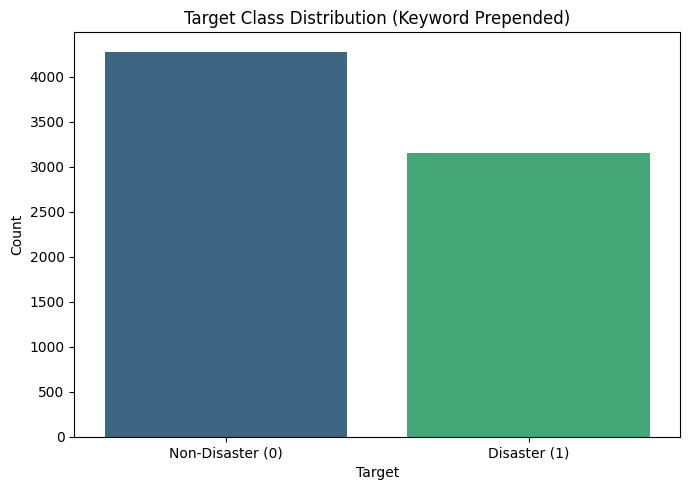

Target Class Counts:
target
0    4278
1    3151
Name: count, dtype: int64

Target Class Proportions:
target
0    57.59 %
1    42.41 %
Name: proportion, dtype: object


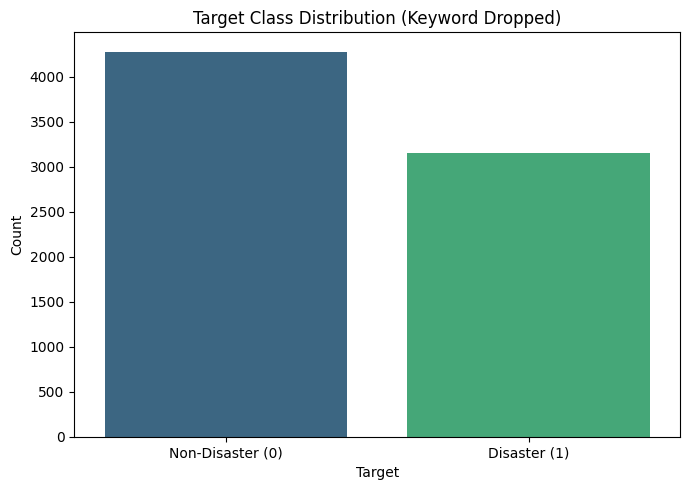

Target Class Counts:
target
0    4280
1    3164
Name: count, dtype: int64

Target Class Proportions:
target
0    57.5 %
1    42.5 %
Name: proportion, dtype: object


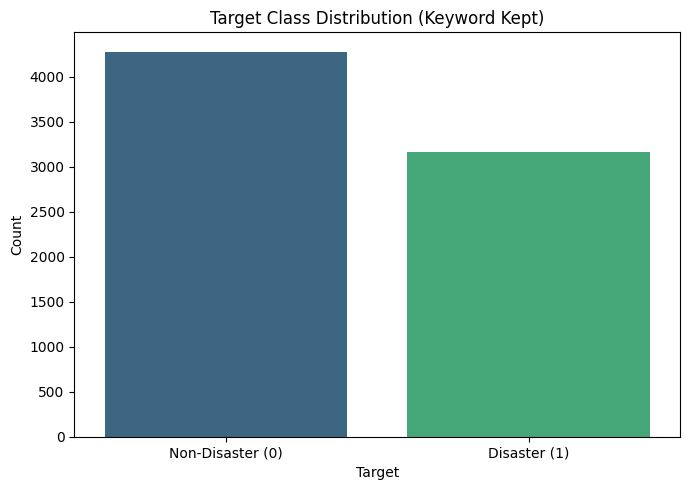

In [ ]:
# Visualize target class distribution for each version of the dataset

plot_target_distribution(df_keyword_prepended, title_suffix=" (Keyword Prepended)")
plot_target_distribution(df_keyword_dropped, title_suffix=" (Keyword Dropped)")
plot_target_distribution(df_keyword_kept, title_suffix=" (Keyword Kept)")


---

> ⚖️ **Class Balance Consideration**  
> A brief review of best practices suggests that datasets with class ratios between **50/50 and 40/60** are generally considered **balanced**.  
>  
> Since our target distribution falls within this range, we will **proceed without applying any class balancing techniques**.

---



### 3.3 📝 Tweet Length Analysis
- Histogram of tweet lengths
- Length distribution per class (0 vs. 1)
- Boxplots
- Sample of longest tweets


In [ ]:
def plot_tweet_length_distribution(df: pd.DataFrame, dataset_name: str = "Dataset"):
    """
    Plots the distribution of tweet lengths overall and by target class.

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset containing at least 'text' and 'target' columns.
    dataset_name : str
        Name of the dataset (used in titles).
    """
    # Calculate tweet lengths if not already present
    if 'length' not in df.columns:
        df['length'] = df['text'].apply(len)

    # Overall Length Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(df['length'], bins=50, kde=False, color='mediumpurple')
    plt.title(f'{dataset_name}: Distribution of Tweet Lengths')
    plt.xlabel('Tweet Length (characters)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Length Distribution by Target
    plt.figure(figsize=(12, 5))
    sns.histplot(
        data=df,
        x='length',
        hue='target',
        bins=50,
        palette='viridis',
        multiple='stack'
    )
    plt.title(f'{dataset_name}: Tweet Length by Class (0 = Non-Disaster, 1 = Disaster)')
    plt.xlabel('Tweet Length (characters)')
    plt.ylabel('Frequency')
    plt.legend(title='Target', labels=['Non-Disaster (0)', 'Disaster (1)'])  # Explicit legend
    plt.tight_layout()
    plt.show()

    # Boxplot by Target
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='target', y='length', data=df, palette='Set2')
    plt.title(f'{dataset_name}: Boxplot of Tweet Lengths by Class')
    plt.xlabel('Target')
    plt.ylabel('Tweet Length')
    plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
    plt.tight_layout()
    plt.show()


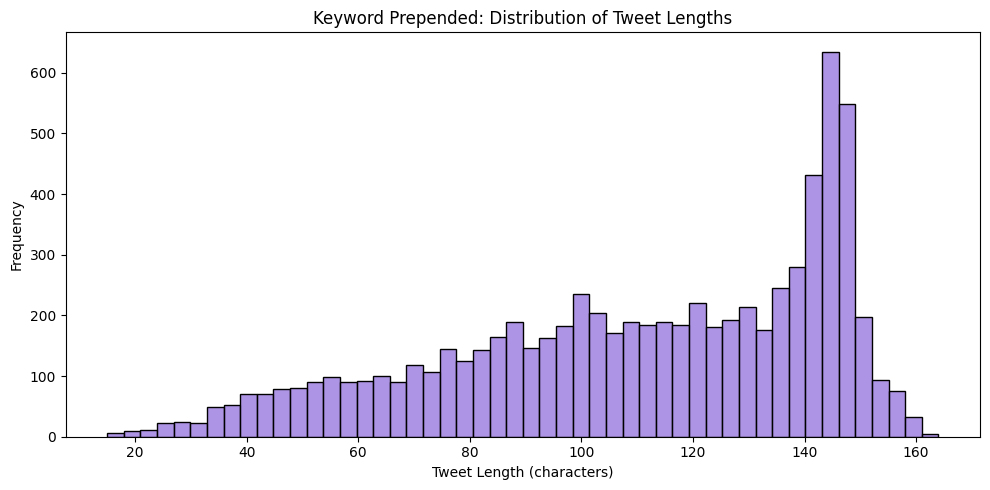

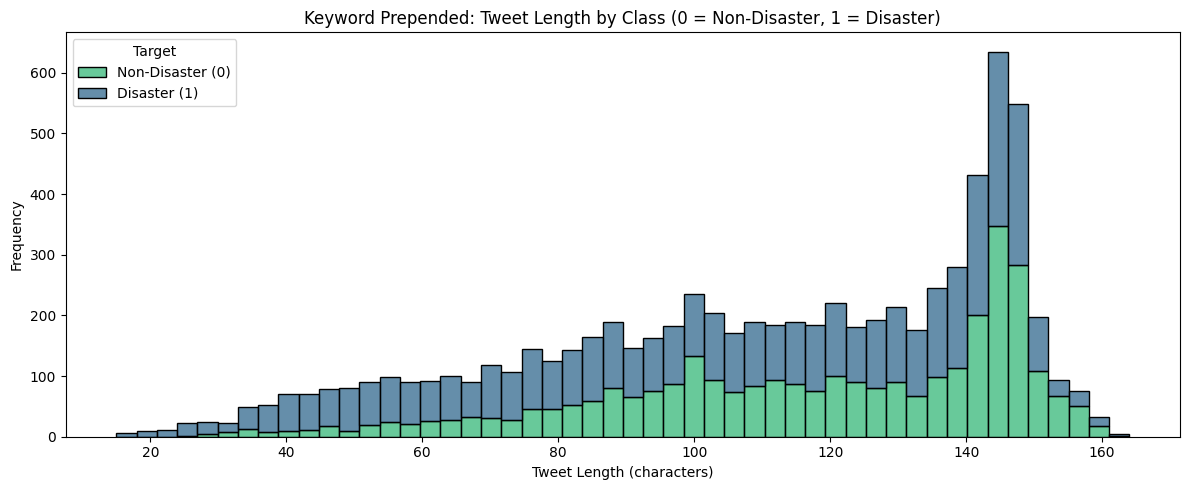

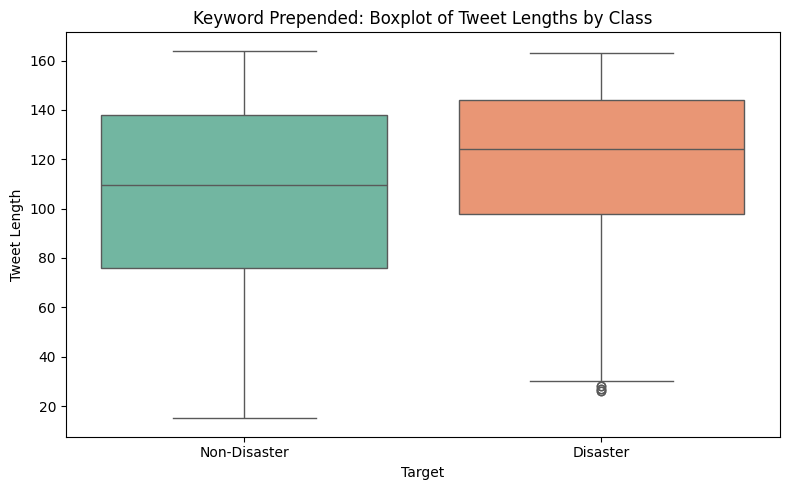

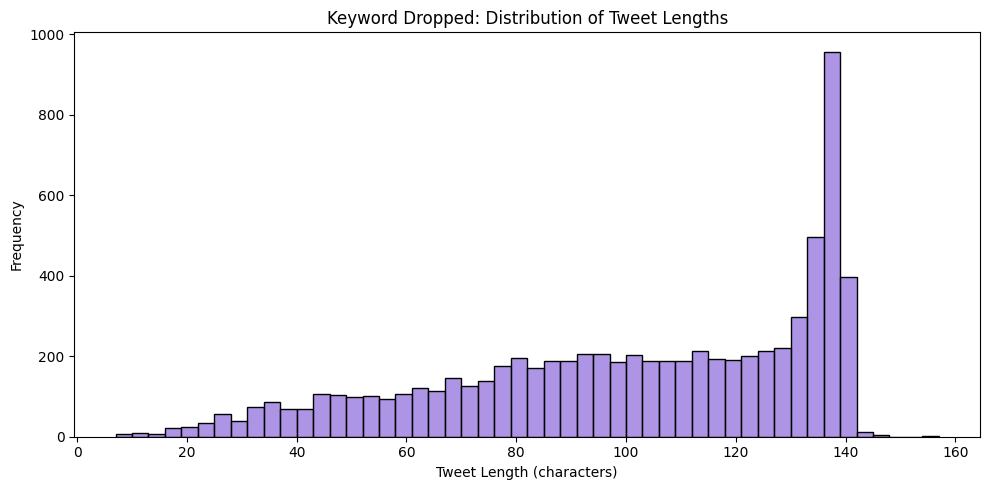

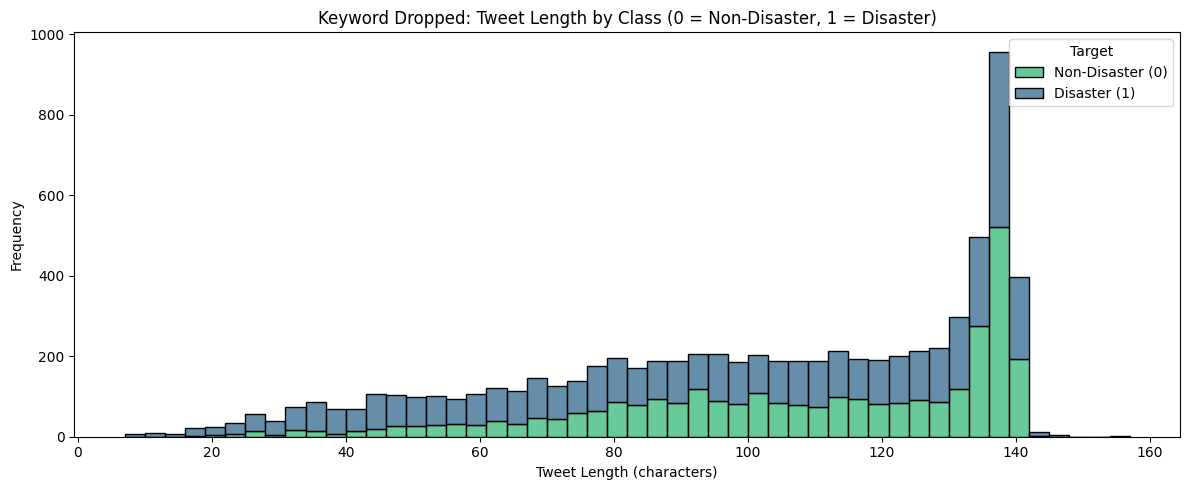

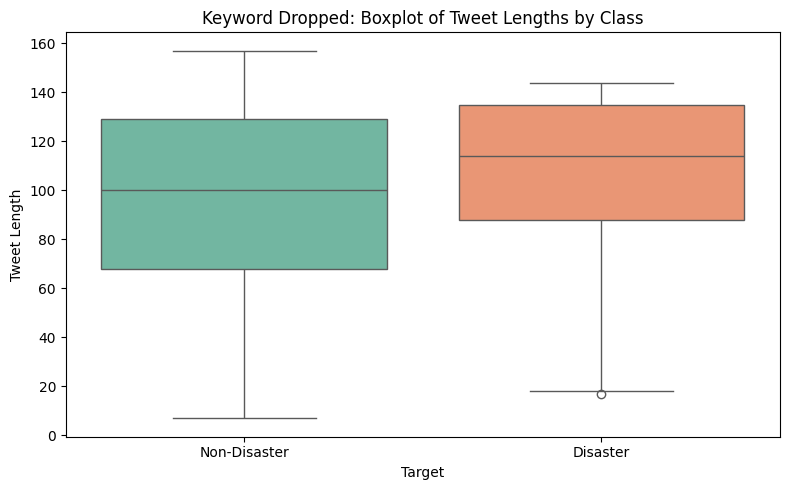

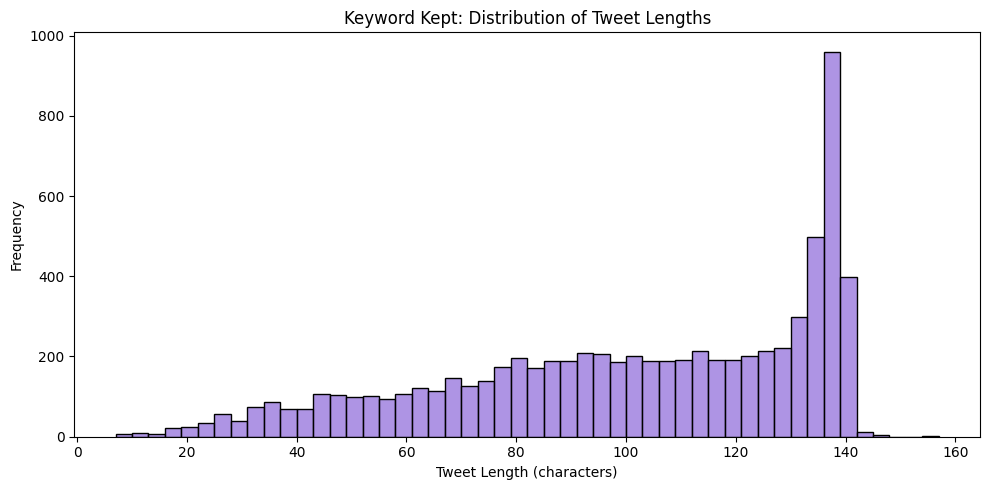

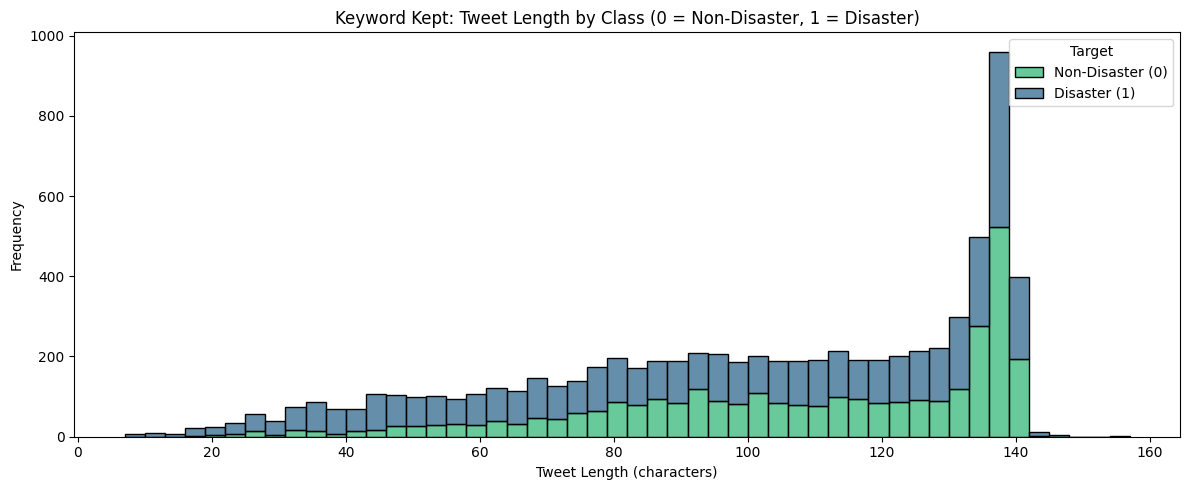

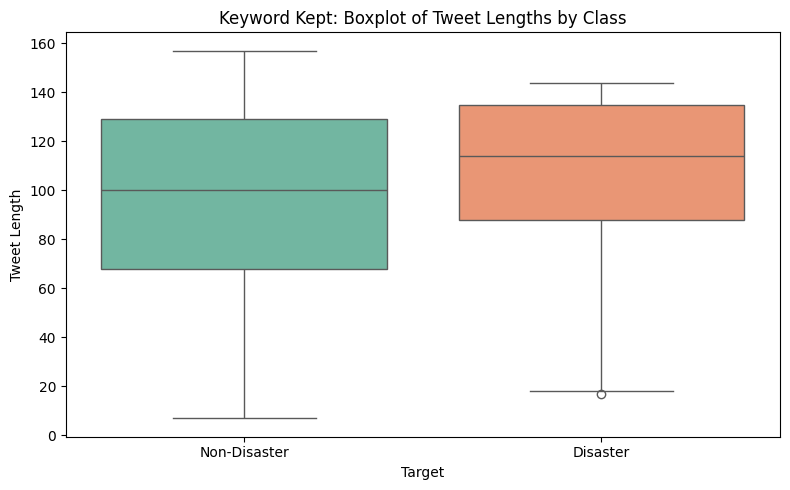

In [ ]:
plot_tweet_length_distribution(df_keyword_prepended, "Keyword Prepended")
plot_tweet_length_distribution(df_keyword_dropped, "Keyword Dropped")
plot_tweet_length_distribution(df_keyword_kept, "Keyword Kept")


### 3.4 🔖 Hashtag Analysis
- Frequency distribution of hashtags per class
- Bar charts for top hashtags in each target group
- Shared hashtags across classes
- Heatmap comparison


In [ ]:
def analyze_hashtags(df: pd.DataFrame, text_col: str = "text", target_col: str = "target", top_n: int = 15):
    """
    Analyzes and visualizes hashtag frequency across target classes.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing tweet text and binary target labels.

    text_col : str, default="text"
        Name of the column containing the tweet text.

    target_col : str, default="target"
        Name of the column containing binary labels (0 or 1).

    top_n : int, default=15
        Number of top hashtags to visualize for each class.

    Returns:
    --------
    Tuple[pd.Series, pd.Series, pd.DataFrame]
        - Hashtag counts for target = 1
        - Hashtag counts for target = 0
        - Common hashtags DataFrame with side-by-side counts
    """
    from collections import Counter
    import matplotlib.pyplot as plt
    import seaborn as sns
    import re

    counter_1 = Counter()
    counter_0 = Counter()
    hashtag_pattern = re.compile(r"#\w+")

    for text, target in zip(df[text_col], df[target_col]):
        hashtags = hashtag_pattern.findall(str(text).lower())
        if target == 1:
            counter_1.update(hashtags)
        elif target == 0:
            counter_0.update(hashtags)

    hashtags_1 = pd.Series(counter_1).sort_values(ascending=False)
    hashtags_0 = pd.Series(counter_0).sort_values(ascending=False)

    # Plotting
    viridis = sns.color_palette("viridis", as_cmap=True)
    color1 = viridis(0.3)
    color2 = viridis(0.8)

    plt.figure(figsize=(10, 5))
    hashtags_1.head(top_n).plot(kind="bar", color=color2)
    plt.title("Top Hashtags (Disaster Tweets)")
    plt.xlabel("Hashtag")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    hashtags_0.head(top_n).plot(kind="bar", color=color1)
    plt.title("Top Hashtags (Non-Disaster Tweets)")
    plt.xlabel("Hashtag")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Shared hashtags
    common_tags = hashtags_1.index.intersection(hashtags_0.index)
    df_common = pd.DataFrame({
        "Disaster": hashtags_1.loc[common_tags],
        "Non-Disaster": hashtags_0.loc[common_tags]
    })

    df_common["total"] = df_common.sum(axis=1)
    df_common = df_common.sort_values("total", ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_common[["Disaster", "Non-Disaster"]], annot=True, cmap="viridis", fmt=".0f")
    plt.title("Top Shared Hashtags: Heatmap Comparison")
    plt.ylabel("Hashtag")
    plt.xlabel("Target Class")
    plt.tight_layout()
    plt.show()

    # ✅ Print total hashtag counts
    print(f"Total hashtags in target=1 (Disaster): {sum(counter_1.values())}")
    print(f"Total hashtags in target=0 (Non-Disaster): {sum(counter_0.values())}")

    return hashtags_1, hashtags_0, df_common


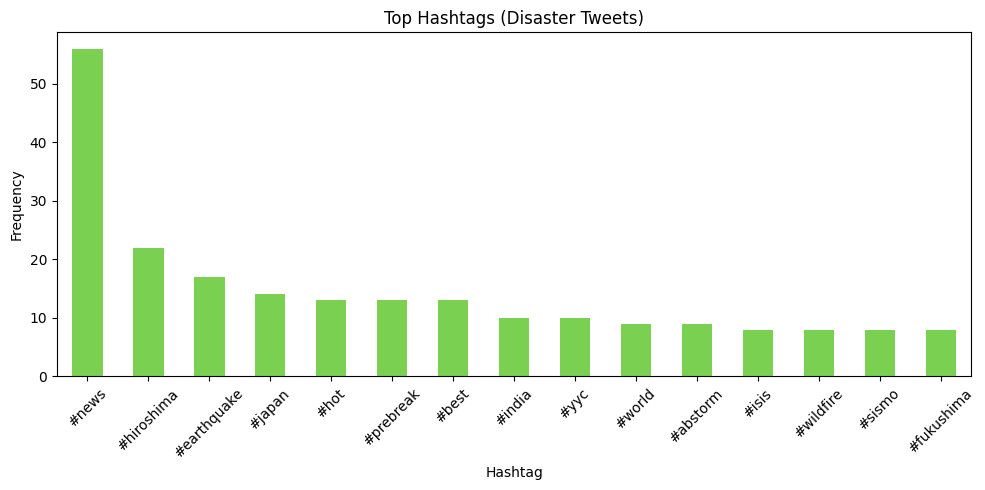

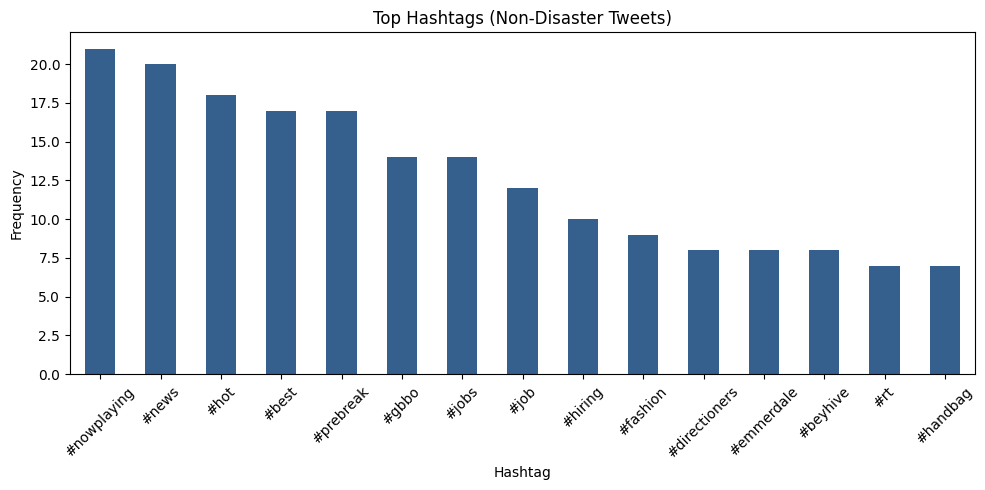

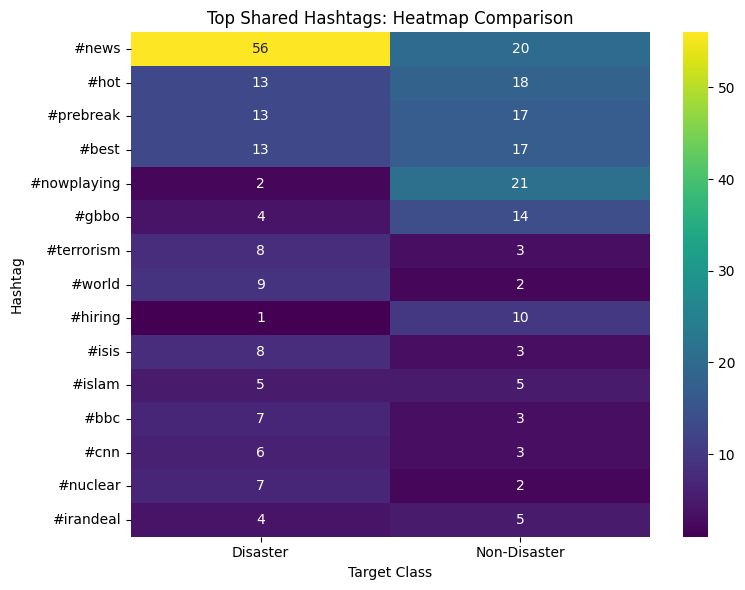

Total hashtags in target=1 (Disaster): 1563
Total hashtags in target=0 (Non-Disaster): 1643


In [ ]:
# Run hashtag analysis on all dataset variations
# hashtags_prepended_1, hashtags_prepended_0, common_hashtags_prepended = analyze_hashtags(df_keyword_prepended)
# hashtags_dropped_1, hashtags_dropped_0, common_hashtags_dropped = analyze_hashtags(df_keyword_dropped)
hashtags_kept_1, hashtags_kept_0, common_hashtags_kept = analyze_hashtags(df_keyword_kept)


### 3.5 👥 Mention (@) Analysis
- Frequency of @mentions by class
- Top mentions visualized
- Comments on usage trends


In [ ]:
def analyze_mentions(df, dataset_label="Dataset"):
    """
    Analyze and visualize @mention usage in tweets, grouped by target class.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'text' and 'target' columns.
    dataset_label : str
        Label used in plot titles to distinguish datasets.

    Returns:
    --------
    None (displays plots and summary stats)
    """
    counter_1 = Counter()
    counter_0 = Counter()

    # Compile pattern for mentions
    mention_pattern = re.compile(r"@\w+")

    for text, target in zip(df["text"], df["target"]):
        mentions = mention_pattern.findall(str(text).lower())
        for mention in mentions:
            if target == 1:
                counter_1[mention] += 1
            else:
                counter_0[mention] += 1

    mentions_target1 = pd.Series(counter_1)
    mentions_target0 = pd.Series(counter_0)

    top_mentions_target1 = mentions_target1.sort_values(ascending=False).head(15)
    top_mentions_target0 = mentions_target0.sort_values(ascending=False).head(15)

    max_count = max(top_mentions_target1.max(), top_mentions_target0.max())
    viridis = sns.color_palette("viridis", as_cmap=True)
    color1 = viridis(0.3)
    color2 = viridis(0.7)

    # Plot for target = 1
    plt.figure(figsize=(10, 6))
    top_mentions_target1.plot(kind="bar", color=color1)
    plt.title(f"Top 15 Mentions in Disaster Tweets (Target=1) - {dataset_label}")
    plt.xlabel("Mention")
    plt.ylabel("Count")
    plt.ylim(0, max_count)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plot for target = 0
    plt.figure(figsize=(10, 6))
    top_mentions_target0.plot(kind="bar", color=color2)
    plt.title(f"Top 15 Mentions in Non-Disaster Tweets (Target=0) - {dataset_label}")
    plt.xlabel("Mention")
    plt.ylabel("Count")
    plt.ylim(0, max_count)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # ✅ Print summary stats
    total_mentions_1 = sum(counter_1.values())
    total_mentions_0 = sum(counter_0.values())
    print(f"Total @mentions in target=1 (Disaster): {total_mentions_1}")
    print(f"Total @mentions in target=0 (Non-Disaster): {total_mentions_0}")


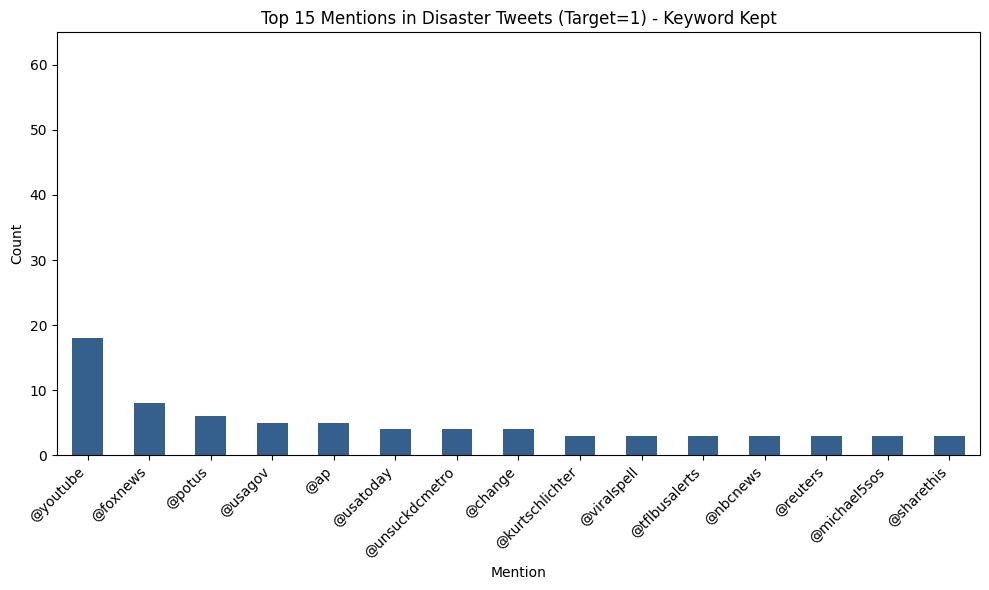

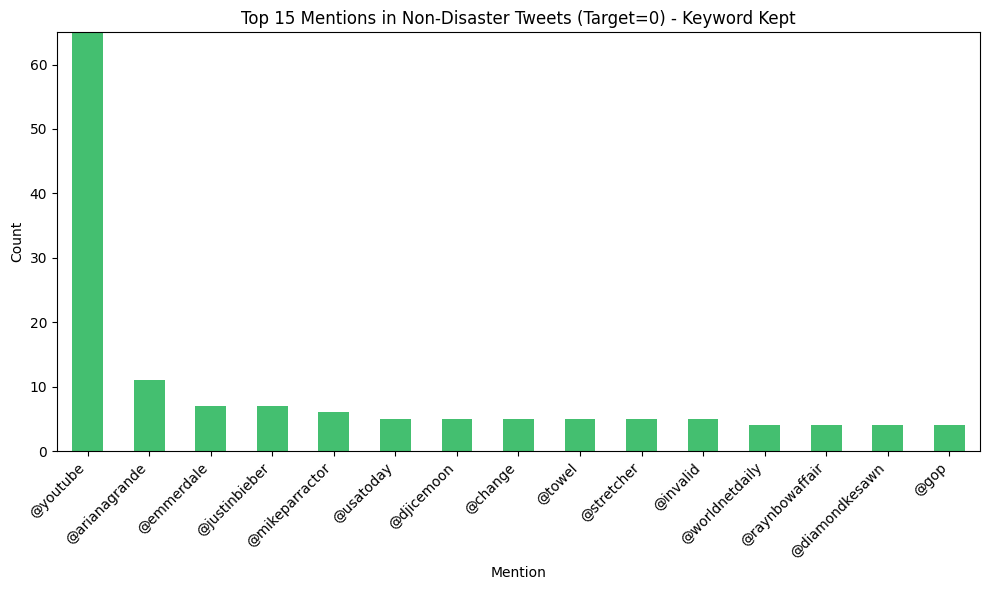

Total @mentions in target=1 (Disaster): 887
Total @mentions in target=0 (Non-Disaster): 1819


In [ ]:
# # 🔍 Analyze mentions in the dataset with keyword prepended to text
# analyze_mentions(df_keyword_prepended, dataset_label="Keyword Prepended")

# # 🔍 Analyze mentions in the dataset with keyword dropped
# analyze_mentions(df_keyword_dropped, dataset_label="Keyword Dropped")

# 🔍 Analyze mentions in the dataset with keyword kept
analyze_mentions(df_keyword_kept, dataset_label="Keyword Kept")

### 3.6 🔗 URL Analysis
- Frequency and examples of URLs
- Distribution by target class
- Bar chart of top URLs


In [ ]:
def analyze_urls(df: pd.DataFrame):
    """
    Analyzes URL usage in tweets, visualizing frequency by target class and top URLs.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with at least 'text' and 'target' columns.
    """

    # Initialize counters for each target
    url_counter_1 = Counter()
    url_counter_0 = Counter()

    # URL regex
    url_pattern = re.compile(r"(https?://\S+|www\.\S+)")

    # Collect URLs by target
    for text, target in zip(df['text'], df['target']):
        urls = url_pattern.findall(str(text).lower())
        for url in urls:
            if target == 1:
                url_counter_1[url] += 1
            elif target == 0:
                url_counter_0[url] += 1

    # Convert to DataFrames
    df_urls_1 = pd.Series(url_counter_1).sort_values(ascending=False).head(15)
    df_urls_0 = pd.Series(url_counter_0).sort_values(ascending=False).head(15)

    # Get unified y-axis limit
    max_count = max(df_urls_1.max(), df_urls_0.max())

    # Define shared color palette
    viridis = sns.color_palette("viridis", as_cmap=True)
    color1 = viridis(0.3)
    color2 = viridis(0.8)

    # Plot target = 1
    plt.figure(figsize=(10, 5))
    df_urls_1.plot(kind='bar', color=color1)
    plt.title('Top 15 URLs in Disaster-Related Tweets (target = 1)')
    plt.xlabel('URL')
    plt.ylabel('Count')
    plt.ylim(0, max_count)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot target = 0
    plt.figure(figsize=(10, 5))
    df_urls_0.plot(kind='bar', color=color2)
    plt.title('Top 15 URLs in Non-Disaster Tweets (target = 0)')
    plt.xlabel('URL')
    plt.ylabel('Count')
    plt.ylim(0, max_count)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Summary stats
    total_urls_1 = sum(url_counter_1.values())
    total_urls_0 = sum(url_counter_0.values())
    print(f"Total URLs in target=1 (Disaster): {total_urls_1}")
    print(f"Total URLs in target=0 (Non-Disaster): {total_urls_0}")


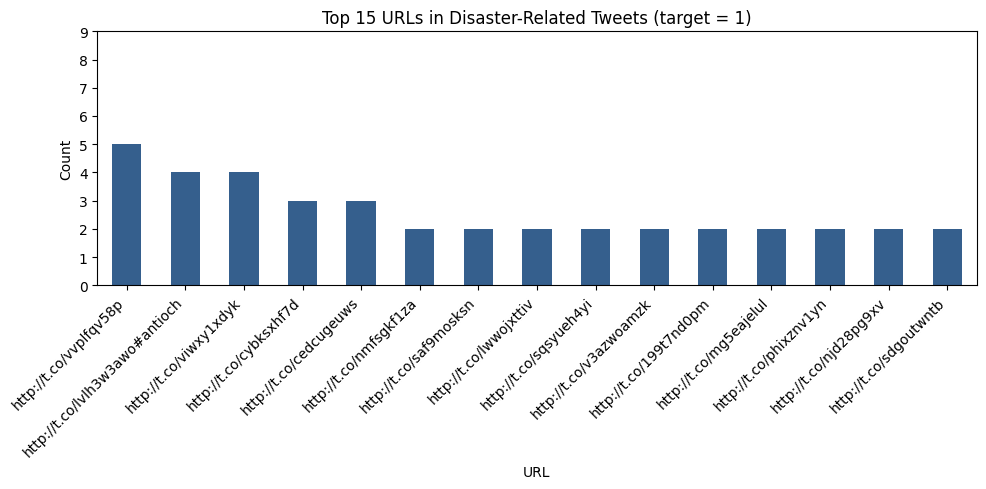

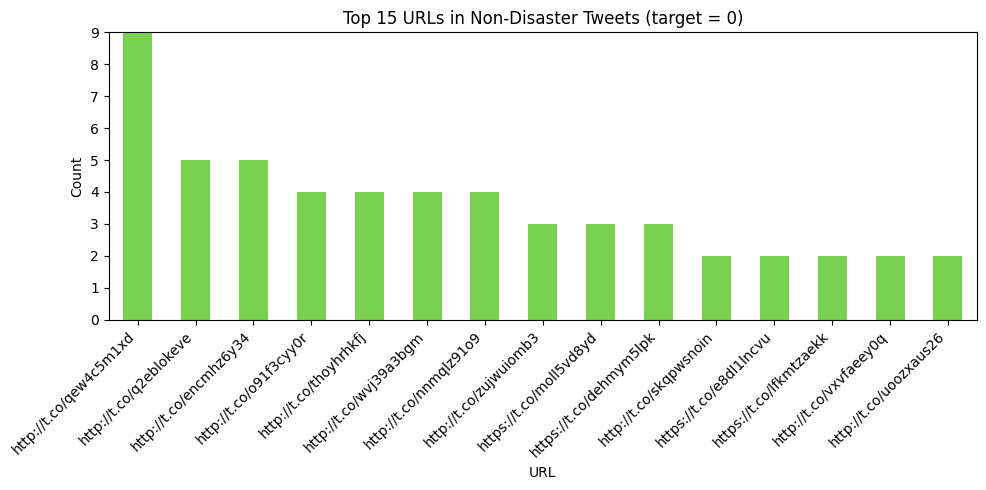

Total URLs in target=1 (Disaster): 2482
Total URLs in target=0 (Non-Disaster): 2190


In [ ]:
# # 🔗 URL Analysis for each cleaned dataset
# analyze_urls(df_keyword_prepended)
# analyze_urls(df_keyword_dropped)
analyze_urls(df_keyword_kept)

### 3.7 😅 Detect Rows with Emojis or ASCII Emoticons
- Detect and count emojis
- Analyze distribution by class
- Visualize presence of common special characters (e.g., ‘!’, ‘#’, ‘:’, etc.)



In [ ]:
def analyze_emojis_and_emoticons(df, text_col="text", target_col="target", dataset_label="Dataset"):
    """
    Detects emoji and emoticon usage in text and visualizes distribution by target class.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the tweet text and binary labels.

    text_col : str, default="text"
        Name of the column containing tweet text.

    target_col : str, default="target"
        Name of the column containing target class.

    dataset_label : str
        Label for titles/plots to distinguish datasets.

    Returns:
    --------
    None
    """
    import re
    from collections import Counter

    emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F700-\U0001F77F"
        "\U0001F780-\U0001F7FF"
        "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA00-\U0001FA6F"
        "\U0001FA70-\U0001FAFF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

    emoticon_pattern = re.compile(r"[:;=xX8][\-^oO']?[\)D\(\]/\\OpP]")

    def contains_special(text):
        text = str(text)
        return bool(emoji_pattern.search(text)) or bool(emoticon_pattern.search(text))

    df["has_special"] = df[text_col].apply(contains_special)

    # Count by target
    counts = df.groupby(target_col)["has_special"].value_counts().unstack().fillna(0)
    counts.index = counts.index.map({0: "Non-Disaster", 1: "Disaster"})

    # Plot
    plt.figure(figsize=(6, 4))
    counts.plot(kind="bar", stacked=True, colormap="viridis")
    plt.title(f"Emoji/Emoticon Usage by Target - {dataset_label}")
    plt.ylabel("Tweet Count")
    plt.xlabel("Target")
    plt.xticks(rotation=0)
    plt.legend(["No Emoji/Emoticon", "Has Emoji/Emoticon"], title="Contains")
    plt.tight_layout()
    plt.show()

    # Print counts
    print(f"Total tweets with emoji/emoticon: {df['has_special'].sum()} out of {len(df)} ({df['has_special'].mean()*100:.2f}%)\n")


<Figure size 600x400 with 0 Axes>

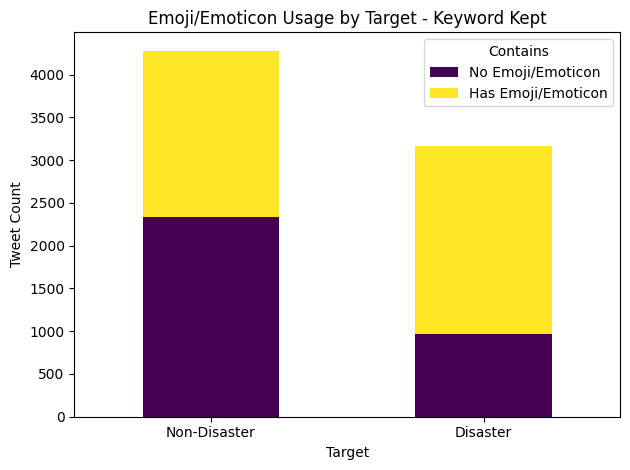

Total tweets with emoji/emoticon: 4145 out of 7444 (55.68%)



In [ ]:
# analyze_emojis_and_emoticons(df_keyword_prepended, dataset_label="Keyword Prepended")
# analyze_emojis_and_emoticons(df_keyword_dropped, dataset_label="Keyword Dropped")
analyze_emojis_and_emoticons(df_keyword_kept, dataset_label="Keyword Kept")


### 3.8 🧵 Sample Tweet Inspection
- Display example tweets by class
- Include edge cases (very short, very long, only special characters, etc.)


In [ ]:
def inspect_sample_tweets(df: pd.DataFrame, dataset_label: str = "Dataset", n_samples: int = 3):
    """
    Display random and edge case tweet examples by target class.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing 'text' and 'target' columns.

    dataset_label : str
        A label for the dataset to include in printed headers.

    n_samples : int, default=3
        Number of random tweets to sample from each class.

    Returns:
    --------
    None
    """
    print(f"\n📄 Sample Tweets from {dataset_label}:\n")

    for label, name in [(0, "Non-Disaster"), (1, "Disaster")]:
        print(f"--- {name} Tweets ---\n")
        samples = df[df["target"] == label]["text"].sample(n=n_samples, random_state=42)
        for idx, tweet in enumerate(samples, 1):
            print(f"{idx}. {tweet}\n")

    print("\n🔎 Edge Case Examples:\n")

    # Shortest tweet
    df["text_length"] = df["text"].apply(len)
    print(f"🧵 Shortest Tweet ({df['text_length'].min()} chars):\n{df.loc[df['text_length'].idxmin(), 'text']}\n")

    # Longest tweet
    print(f"🧵 Longest Tweet ({df['text_length'].max()} chars):\n{df.loc[df['text_length'].idxmax(), 'text']}\n")

    # Only special characters
    special_only = df[df["text"].str.match(r"^[^\w\s]+$", na=False)]
    if not special_only.empty:
        print("🧵 Tweet with only special characters:\n", special_only.iloc[0]["text"], "\n")

    # Only whitespace or empty
    whitespace_only = df[df["text"].str.strip() == ""]
    if not whitespace_only.empty:
        print("🧵 Empty or whitespace-only tweet:\n", whitespace_only.iloc[0]["text"], "\n")

    # Only emoji or emoticon
    emoji_emoticon_only = df[df["text"].apply(lambda x: bool(re.fullmatch(r"[\W\d_]+", str(x).strip())))]
    if not emoji_emoticon_only.empty:
        print("🧵 Emoji/Emoticon-only tweet:\n", emoji_emoticon_only.iloc[0]["text"], "\n")

    # Drop helper column
    df.drop(columns="text_length", inplace=True)


In [ ]:
# inspect_sample_tweets(df_keyword_prepended, dataset_label="Keyword Prepended")
inspect_sample_tweets(df_keyword_dropped, dataset_label="Keyword Dropped")
# inspect_sample_tweets(df_keyword_kept, dataset_label="Keyword Kept")



📄 Sample Tweets from Keyword Dropped:

--- Non-Disaster Tweets ---

1. Blood Group  A +ve is associated with Gastric Carcinoma says text book...Another fragile gene in my body....

2. Morgan Silver Dollar 1921 P CH Gem Bu PL Blazing MS++++++ Satin Rare Proof Like! - Full re_ http://t.co/99MbyFl3Id http://t.co/4ddMTguZzS

3. Entertain this thought for a moment: diarrhea hurricane

--- Disaster Tweets ---

1. Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/KuKmAL605a

2. Grace: here are damage levels USA style.. #Taiwan #China #world hurricane/typhoon ratings/categories defined again http://t.co/OdYdT9QPk1

3. The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/RlPTtkBG4W


🔎 Edge Case Examples:

🧵 Shortest Tweet (7 chars):
Crushed

🧵 Longest Tweet (157 chars):
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned????????????

---

## 4. 🔄 Text Preprocessing Variants <a name="preprocessing-variants"></a>

We apply multiple preprocessing strategies to generate diverse versions of the tweet dataset for model comparison. Each variant is saved independently and labeled for later use.

### ✅ Preprocessing Base Versions
Each variant is generated from three base datasets:
- **Keyword Prepended** – `df_keyword_prepended`
- **Keyword Dropped** – `df_keyword_dropped`
- **Keyword Kept** – `df_keyword_kept`

### 🧪 Variant Descriptions

| Variant | Description |
|:--------|:------------|
| **v1_basic_clean** | Lowercased, punctuation removed, stopwords removed. Emojis and mentions are *kept*. |
| **v2_no_emojis_mentions** | v1 + Emojis and @mentions are removed. |
| **v3_lemmatized** | v1 + Lemmatization applied. |
| **v4_stemmed** | v1 + Stemming applied. |
| **v5_lemma_stem** | v1 + Lemmatization and stemming applied sequentially. |
| **v6_custom_stopwords** | v1 + Lemmatization + expanded stopword list (common Twitter words like 'rt', 'im', etc.). |
| **v7_lowercase_words_only** | v1 + Numbers removed + keep only lowercase alphabetic tokens. |
| **v8_keep_hashtags** | v1 + Lemmatization applied + hashtags preserved instead of stripped. |
| **v9_minimal_processing** | Minimal cleaning: No stopword removal, no emoji or mention removal, no URL stripping, no lemmatization or stemming (baseline variant). |
| **v10_lemma_stem_custom_stopwords** | Lemmatization + stemming + extended stopword list. Emojis and mentions are *kept*. |

> *Variants were designed to test the impact of incremental text cleaning steps on model performance.*

Each variant is stored in the `final_processed/` directory with a filename structure like:

```
final_processed/{df_label}v{variant_number}{variant_name}.csv
```


**Examples:**
- `final_processed/prepended_v3_lemmatized.csv`
- `final_processed/dropped_v6_custom_stopwords.csv`
- `final_processed/kept_v10_lemma_stem_custom_stopwords.csv`

---

In [ ]:
# Setup
base_stopwords = set(stopwords.words('english'))
extra_stopwords = {
    "get", "he", "that", "didnt", "doesnt", "dont", "isnt", "ive", "know",
    "least", "let", "like","may", "much", "must", "never", "one", "other", "rt",
    "said", "see", "seem", "she", "take", "thank", "there", "though", "still",
    "us", "use", "want", "wasnt", "way", "well", "what", "without", "wont",
    "would", "yet", "your", "im"
}
punctuation = set(string.punctuation)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
tweet_tokenizer = TweetTokenizer()

def preprocess_text(
    text,
    lowercase=True,
    remove_stopwords=True,
    remove_emojis=True,
    remove_mentions=True,
    remove_urls=True,
    remove_numbers=True,
    lemmatize=False,
    stem=False,
    keep_hashtags=False,
    use_extra_stopwords=False,
    alpha_only=False,
    tokenizer=tweet_tokenizer
):
    try:
        if not isinstance(text, str) or text.strip() == "":
            return ""

        if lowercase:
            text = text.lower()

        if remove_emojis:
            emoji_pattern = re.compile("["
                "\U0001F600-\U0001F64F"
                "\U0001F300-\U0001F5FF"
                "\U0001F680-\U0001F6FF"
                "\U0001F700-\U0001F77F"
                "\U0001F780-\U0001F7FF"
                "\U0001F800-\U0001F8FF"
                "\U0001F900-\U0001F9FF"
                "\U0001FA00-\U0001FA6F"
                "\U0001FA70-\U0001FAFF"
                "\U00002702-\U000027B0"
                "\U000024C2-\U0001F251"
                "]+", flags=re.UNICODE)
            text = emoji_pattern.sub('', text)

        if remove_mentions:
            text = re.sub(r"@\w+", "", text)

        if remove_urls:
            text = re.sub(r"http\S+|www\.\S+", "", text)

        if not keep_hashtags:
            text = re.sub(r"#", "", text)

        if remove_numbers:
            text = re.sub(r'\S*\d\S*', '', text)

        text = re.sub(r"[^\w\s]", "", text)
        tokens = tokenizer.tokenize(text)

        if alpha_only:
            tokens = [t for t in tokens if t.isalpha()]

        if remove_stopwords:
            stop_set = base_stopwords | punctuation
            if use_extra_stopwords:
                stop_set = stop_set | extra_stopwords
            tokens = [t for t in tokens if t not in stop_set]

        if lemmatize:
            tokens = [lemmatizer.lemmatize(t) for t in tokens]

        if stem:
            tokens = [stemmer.stem(t) for t in tokens]

        return " ".join(tokens)

    except Exception as e:
        print(f"[WARNING] Preprocessing failed for: {repr(text)}\n→ {e}")
        return ""


In [ ]:
def generate_text_variants(df: pd.DataFrame, df_label: str = "prepended", output_dir: str = "processed"):
    """
    Generates and saves multiple preprocessed versions of a tweet dataset.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing a 'text' column.

    df_label : str, default="prepended"
        Label prefix to use in saved filenames (e.g., "prepended_v1_basic_clean.csv").

    output_dir : str, default="processed"
        Directory to save the processed datasets.

    Returns:
    --------
    None
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    variants = {
        "v1_basic_clean": {"remove_emojis": False, "remove_mentions": False},
        "v2_no_emojis_mentions": {"remove_emojis": True, "remove_mentions": True},
        "v3_lemmatized": {"lemmatize": True},
        "v4_stemmed": {"stem": True},
        "v5_lemma_stem": {"lemmatize": True, "stem": True},
        "v6_custom_stopwords": {"lemmatize": True, "use_extra_stopwords": True},
        "v7_lowercase_words_only": {"remove_numbers": True, "alpha_only": True},
        "v8_keep_hashtags": {"lemmatize": True, "keep_hashtags": True},
        "v9_minimal_processing": {
            "remove_stopwords": False,
            "remove_emojis": False,
            "remove_mentions": False,
            "remove_urls": False,
            "lemmatize": False,
            "stem": False
        },
        "v10_lemma_stem_custom_stopwords": {
            "lemmatize": True,
            "stem": True,
            "use_extra_stopwords": True,
            "remove_emojis": False,
            "remove_mentions": False
        }
    }


    for name, options in variants.items():
        variant_df = df.copy()
        variant_df["processed_text"] = variant_df["text"].apply(lambda x: preprocess_text(x, **options))
        save_path = f"{output_dir}/{df_label}_{name}.csv"
        variant_df.to_csv(save_path, index=False)
        print(f"✅ Saved: {save_path}")


In [ ]:
generate_text_variants(df_keyword_prepended, df_label="prepended", output_dir="final_processed")
generate_text_variants(df_keyword_dropped, df_label="dropped", output_dir="final_processed")
generate_text_variants(df_keyword_kept, df_label="kept", output_dir="final_processed")

✅ Saved: final_processed/prepended_v1_basic_clean.csv
✅ Saved: final_processed/prepended_v2_no_emojis_mentions.csv
✅ Saved: final_processed/prepended_v3_lemmatized.csv
✅ Saved: final_processed/prepended_v4_stemmed.csv
✅ Saved: final_processed/prepended_v5_lemma_stem.csv
✅ Saved: final_processed/prepended_v6_custom_stopwords.csv
✅ Saved: final_processed/prepended_v7_lowercase_words_only.csv
✅ Saved: final_processed/prepended_v8_keep_hashtags.csv
✅ Saved: final_processed/prepended_v9_minimal_processing.csv
✅ Saved: final_processed/prepended_v10_lemma_stem_custom_stopwords.csv
✅ Saved: final_processed/dropped_v1_basic_clean.csv
✅ Saved: final_processed/dropped_v2_no_emojis_mentions.csv
✅ Saved: final_processed/dropped_v3_lemmatized.csv
✅ Saved: final_processed/dropped_v4_stemmed.csv
✅ Saved: final_processed/dropped_v5_lemma_stem.csv
✅ Saved: final_processed/dropped_v6_custom_stopwords.csv
✅ Saved: final_processed/dropped_v7_lowercase_words_only.csv
✅ Saved: final_processed/dropped_v8_keep

---

## 5. 🌥️ Word Clouds & Frequency Comparison <a name="wordclouds"></a>

This section generates word clouds and frequency bar charts for each preprocessed dataset to visualize word usage patterns. For each variant, we analyze:

- **Overall Word Cloud**: Most frequent words across all tweets.
- **Class-Wise Word Clouds**: Separate word clouds for disaster (`target = 1`) and non-disaster (`target = 0`) tweets.
- **Top Word Frequency Bar Charts**: Comparing high-frequency tokens across classes.

These visualizations help identify which preprocessing strategies retain the most meaningful features and how class distinctions are reflected in word usage.

---


In [ ]:
def load_processed_datasets(folder_path="final_processed"):
    """
    Load all processed datasets from a folder into a dictionary.

    Returns:
    --------
    dict: {filename_without_ext: DataFrame}
    """
    datasets = {}
    for fname in os.listdir(folder_path):
        if fname.endswith(".csv"):
            name = fname.replace(".csv", "")
            datasets[name] = pd.read_csv(os.path.join(folder_path, fname))
    return datasets


In [ ]:
def save_word_stats(df, dataset_label, text_col="processed_text", target_col="target", top_n=20, output_dir="wordclouds"):
    """
    Generate and save word clouds and frequency bar plots to disk.

    Parameters:
    -----------
    df : pd.DataFrame
        The processed dataset containing at least 'processed_text' and 'target' columns.
    dataset_label : str
        A unique label identifying this dataset (used as the folder name).
    text_col : str
        Column name containing processed tweet text.
    target_col : str
        Column containing binary labels (0 or 1).
    top_n : int
        Number of top words to show in bar plots.
    output_dir : str
        Parent directory to save word clouds and plots.
    """
    subdir = os.path.join(output_dir, dataset_label)
    os.makedirs(subdir, exist_ok=True)

    # Frequency counts
    tokens_all = " ".join(df[text_col].astype(str)).split()
    tokens_0 = " ".join(df[df[target_col] == 0][text_col].astype(str)).split()
    tokens_1 = " ".join(df[df[target_col] == 1][text_col].astype(str)).split()

    counter_all = Counter(tokens_all)
    counter_0 = Counter(tokens_0)
    counter_1 = Counter(tokens_1)

    viridis = sns.color_palette("viridis", as_cmap=True)

    # Word Cloud Generation
    for counter, label in zip(
        [counter_all, counter_0, counter_1],
        ["all", "target0", "target1"]
    ):
        wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=1000)
        wc.generate_from_frequencies(counter)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{label.capitalize()} - {dataset_label}")
        plt.tight_layout()
        path = os.path.join(subdir, f"wordcloud_{label}.png")
        plt.savefig(path)
        plt.close()

    # Frequency Bar Charts
    for counter, label in zip([counter_0, counter_1], ["target0", "target1"]):
        top_words = counter.most_common(top_n)
        words, freqs = zip(*top_words)
        plt.figure(figsize=(12, 5))
        sns.barplot(x=list(words), y=list(freqs), palette="viridis")
        plt.title(f"Top {top_n} Words for {label} - {dataset_label}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        path = os.path.join(subdir, f"freqplot_{label}.png")
        plt.savefig(path)
        plt.close()

    print(f"Saved word cloud and frequency plots for: {dataset_label}")


In [ ]:
for file in os.listdir("final_processed"):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join("final_processed", file))
        label = file.replace(".csv", "")
        save_word_stats(df, dataset_label=label)


---
## 6. 🤖 Baseline Modeling Pipeline <a name="baseline-modeling"></a>

This section documents the Baseline Modeling Pipeline used for the initial HPC workflow.  
Because this pipeline processes 30 different datasets across six classifiers with cross-validation and learning curve generation, it is computationally intensive and is **not recommended to run on a typical laptop or desktop machine**.  For user convenience, the final hypertuned best model results are listed in a pandas dataframe in section 8.2.

All baseline models were trained and evaluated on an HPC system using batch scheduling to ensure timely completion.

- Load Preprocessed Datasets
- Define Baseline Classifier Pipelines
- Apply TF-IDF Vectorization
- Train/Test Split (80/20)
- Train Baseline Models:
  - Multinomial Naive Bayes
  - Logistic Regression
  - Passive Aggressive Classifier
  - Support Vector Machine
  - K-Nearest Neighbors
  - Neural Network (MLP)
- Evaluate Models (Cross-Validation + Test Set)
- Save Performance Metrics

Each model's performance is evaluated using cross-validation and on a held-out test set.

### 📂 Source Files
- [pipeline_modules.py](./pipeline_modules.py) — Baseline modeling code
- [run_pipeline.py](./run_pipeline.py) — Script to execute baseline workflows
- [run_pipeline.sh](./run_pipeline.sh) — Batch script to coordinate HPC array runs
- [merge_results.py](./merge_results.py) — Merge evaluation results across datasets and models
- [dataset_list.txt](./dataset_list.txt) — List of all dataset variants to process

The HPC jobs were scheduled on the Impulse cluster using 28 CPU cores and 16 GB memory per task, with a 4-hour walltime limit, and executed as an array job over 30 datasets.



---

### 6.1 📂 Load Preprocessed Datasets  
Load all text-processed CSVs and prepare `(X, y)` pairs for modeling.

---

In [ ]:
def load_xy_datasets(folder_path="final_processed", text_col="processed_text", target_col="target"):
    """
    Load processed datasets and return (X, y) tuples for modeling.
    Drops rows with NaN values in either the text or target columns.

    Parameters:
    -----------
    folder_path : str
        Directory containing the processed CSV files.
    text_col : str
        Name of the column containing cleaned text.
    target_col : str
        Name of the column containing target labels.

    Returns:
    --------
    dict
        Dictionary mapping file names to (X, y) tuples.
    """
    xy_datasets = {}
    nan_report = {}

    for fname in os.listdir(folder_path):
        if fname.endswith(".csv"):
            path = os.path.join(folder_path, fname)
            name = fname.replace(".csv", "")
            df = pd.read_csv(path)

            # Count initial NaNs
            nans_before = df[[text_col, target_col]].isna().sum().sum()

            # Drop NaNs in either column
            df = df.dropna(subset=[text_col, target_col]).reset_index(drop=True)

            nans_after = df[[text_col, target_col]].isna().sum().sum()
            if nans_before > 0:
                nan_report[name] = nans_before

            if text_col in df.columns and target_col in df.columns:
                xy_datasets[name] = (df[text_col], df[target_col])

    print(f"\n📥 Loaded {len(xy_datasets)} datasets.")

    if nan_report:
        print("\n⚠️ Datasets with NaNs (before cleaning):")
        for name, count in nan_report.items():
            print(f" - {name}: {count} NaNs removed")

    return xy_datasets



---

### 6.2 🔧 Define Baseline Classifier Pipelines  
Set up pipelines for each classifier with TF-IDF + model combinations.
- Apply TF-IDF Vectorization

---

In [ ]:
# Common TF-IDF config for all models
tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.8,
    ngram_range=(1, 3)
)

# Define pipelines
pipelines = {
    'MultinomialNB': Pipeline([
        ('tfidf', tfidf),
        ('clf', MultinomialNB())
    ]),
    'LogisticRegression': Pipeline([
        ('tfidf', tfidf),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'PassiveAggressive': Pipeline([
        ('tfidf', tfidf),
        ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=42))
    ]),
    'SVM': Pipeline([
        ('tfidf', tfidf),
        ('clf', SVC(kernel='linear', C=1.0, probability=True, random_state=42))
    ]),
    'KNN': Pipeline([
        ('tfidf', tfidf),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    'NeuralNetwork': Pipeline([
        ('tfidf', tfidf),
        ('clf', MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, verbose=True,
        random_state=42))
    ])
}

### 6.3 🚀 Train and Evaluate Baseline Models

We now train and evaluate each classifier on every processed dataset using 5-fold Stratified Cross-Validation, followed by evaluation on a held-out test set. Metrics such as Accuracy, Precision, Recall, F1 Score, and ROC AUC are recorded.

---


In [ ]:
def plot_learning_curve(estimator, title, X, y, cv, scoring='accuracy', n_jobs=-1, save_path=None):

    # Use viridis colormap to get consistent, soft shades
    viridis = cm.get_cmap('viridis')
    train_color = to_hex(viridis(0.25))  # bluish-teal
    test_color = to_hex(viridis(0.65))   # greenish

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(facecolor='white')
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel(scoring.capitalize())
    plt.grid(alpha=0.3)

    # Soft shading
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color=train_color)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color=test_color)

    plt.plot(train_sizes, train_scores_mean, 'o-', color=train_color, label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color=test_color, label="Validation Score")

    plt.legend(loc="best")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


In [ ]:
def evaluate_models(xy_datasets, pipelines, cv_folds=5, random_state=42, output_dir="performance_metrics3"):

    results = []

    viridis = cm.get_cmap('viridis', 256)
    viridis_light = ListedColormap(viridis(np.linspace(0.2, 0.8)))  # focus on mid-range


    for dataset_name, (X, y) in xy_datasets.items():
        print(f"\n📦 Dataset: {dataset_name} ({len(X)} samples)")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=random_state
        )

        for model_name, pipeline in pipelines.items():
            print(f"  🔍 Evaluating: {model_name}")
            combo_name = f"{dataset_name}_{model_name}"
            save_dir = os.path.join(output_dir, combo_name)
            os.makedirs(save_dir, exist_ok=True)

            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
            acc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy').mean()
            prec = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='precision').mean()
            rec = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall').mean()
            f1 = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1').mean()

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            try:
                if hasattr(pipeline.named_steps['clf'], 'predict_proba'):
                    y_scores = pipeline.predict_proba(X_test)[:, 1]
                else:
                    y_scores = pipeline.decision_function(X_test)
                roc = roc_auc_score(y_test, y_scores)
            except Exception:
                roc = np.nan
                y_scores = None

            results.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC AUC': roc
            })

            # ROC Curve
            if y_scores is not None:
                fpr, tpr, _ = roc_curve(y_test, y_scores)
                plt.figure()
                plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc:.2f})', color=to_hex(viridis(0.6)))
                plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
                plt.grid(alpha=0.3)
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve — {model_name} on {dataset_name}')
                plt.legend(loc='lower right')
                plt.tight_layout()
                plt.savefig(os.path.join(save_dir, "roc_curve.png"))
                plt.close()

            # Confusion Matrix
            cmatrix = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(
                cmatrix,
                annot=True,
                fmt='d',
                # cmap=sns.light_palette("seagreen", as_cmap=True),
                cmap=viridis_light,
                cbar=False,
                linewidths=0.5,
                linecolor='white',
                square=True,
                annot_kws={"size": 12},
                xticklabels=pipeline.classes_,
                yticklabels=pipeline.classes_
            )
            plt.title(f'Confusion Matrix — {model_name} on {dataset_name}')
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
            plt.close()

            # Learning Curve
            print(f"📈 Plotting learning curve for {model_name} on {dataset_name}...")
            plot_learning_curve(
                pipeline,
                f"Learning Curve — {model_name} on {dataset_name}",
                X_train,
                y_train,
                cv=cv,
                save_path=os.path.join(save_dir, "learning_curve.png")
            )

    # Sort by F1 Score in descending order
    results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

    return results_df

### 6.4 💾 Run Baseline Workflow & Save Evaluation Metrics

After model evaluation, the performance metrics for each (dataset, model) pair are saved as CSV files under the applicable `performance_metrics/` directory for further analysis and visualization.

---


In [ ]:
# Grab the dataset name from the command-line
dataset_name = sys.argv[1]

xy_all = load_xy_datasets("final_processed")

if dataset_name not in xy_all:
    print(dataset_name)
    raise ValueError(f"{dataset_name} not found in final_processed/")

xy_subset = {dataset_name: xy_all[dataset_name]}

# Only returns results_df now
results_df = evaluate_models(xy_subset, pipelines)

# Save raw results to CSV
results_df.to_csv(f"performance_metrics3/{dataset_name}_results.csv", index=False)


```bash
#!/bin/bash
#SBATCH --account=hpcadmins
#SBATCH --partition=batch-impulse
#SBATCH --cpus-per-task=28
#SBATCH --mem=16G
#SBATCH --time=04:00:00
#SBATCH --array=0-29

# Load your environment
. /opt/ohpc/pub/spack/v0.21.1/share/spack/setup-env.sh
spack load py-matplotlib@3.7 py-scikit-learn@1.3.2  py-seaborn@0.12.2

# Read the dataset name from the array index
DATASET_NAME=$(sed -n "$((SLURM_ARRAY_TASK_ID + 1))p" dataset_list.txt)

echo "Processing dataset: $DATASET_NAME"
START=$(date +%s)
time python run_pipeline.py "$DATASET_NAME"
END=$(date +%s)

echo "Elapsed time: $((END - START)) seconds"

```

## 7. 🔧 Hyperparameter Tuning Pipeline <a name="hyperparameter-tuning"></a>

This section documents the Hyperparameter Tuning Pipeline used to further optimize our classifiers based on cross-validated performance.

Because hypertuning explores a large search space of hyperparameter combinations using `GridSearchCV` across multiple datasets, it is even **more computationally intensive than the baseline modeling**. For user convenience, the final hypertuned best model results are listed in a pandas dataframe in section 8.2.

It was therefore also executed on the Impulse HPC cluster using array jobs to parallelize tuning across datasets.

- Define model-specific hyperparameter search spaces
- Run `GridSearchCV` to find the best hyperparameters
- Train models with best settings
- Evaluate tuned models with Stratified Cross-Validation and Test Sets
- Save tuned model results and best model summaries

### 📂 Source Files
- [pipeline_modules_ht.py](./pipeline_modules_ht.py) — Hypertuning modeling code
- [run_pipeline_ht.py](./run_pipeline_ht.py) — Script to run hypertuning workflows
- [run_pipeline_ht.sh](./run_pipeline_ht.sh) — Batch script to coordinate hypertuning HPC runs
- [merge_results.py](./merge_results.py) — Merge hypertuned evaluation results
- [dataset_list.txt](./dataset_list.txt) — List of all dataset variants to process

> 🚀 **Note:** HPC jobs were scheduled with the same resource configuration as the baseline modeling (28 CPU cores, 16 GB memory per task, 4-hour walltime limit), but hypertuning generally took longer per dataset due to the exhaustive parameter search.

---



---

### 7.1 🛠️ Define GridSearchCV Search Spaces

We define tailored hyperparameter search spaces for each model using dictionaries compatible with `GridSearchCV`.  
Each search space is designed to optimize model-specific parameters such as regularization strength, learning rates, hidden layer sizes, and kernel types.

---

### **Multinomial Naive Bayes (MultinomialNB)**
- `alpha`: Smoothing parameter (Laplace smoothing) to handle zero counts for unseen words.

---

### **Passive Aggressive Classifier**
- `C`: Regularization strength; lower values imply stronger regularization.
- `max_iter`: Maximum number of training iterations.
- `tol`: Tolerance for stopping criteria (used for convergence).

---

### **Neural Network (MLPClassifier)**
- `hidden_layer_sizes`: Number of neurons per hidden layer (e.g., `(50, 50)` = 2 layers of 50).
- `activation`: Activation function such as `'relu'` or `'tanh'`.
- `solver`: Optimization algorithm; `'adam'` is adaptive and efficient.
- `alpha`: L2 regularization parameter (helps prevent overfitting).
- `learning_rate`: Strategy for adjusting the learning rate during training.
- `early_stopping`: Stop training when validation score stops improving.
- `validation_fraction`: Percentage of training data used for validation during early stopping.
- `n_iter_no_change`: Number of epochs without improvement before stopping.

---

### **Logistic Regression**
- `C`: Inverse of regularization strength (smaller values specify stronger regularization).
- `penalty`: Type of regularization term (`'l2'` for Ridge-style regularization).
- `solver`: Optimization algorithm (`'lbfgs'` is efficient for multiclass problems).
- `max_iter`: Maximum number of iterations for the optimization algorithm.

---

### **Support Vector Machine (SVM)**
- `C`: Regularization strength (higher values reduce regularization).
- `kernel`: Specifies the kernel type to be used in the algorithm (`'linear'` or `'rbf'`).
- `gamma`: Kernel coefficient for `'rbf'`; controls the influence of single training examples.

---

### **K-Nearest Neighbors (KNN)**
- `n_neighbors`: Number of neighbors to use for prediction.
- `weights`: Weight function used in prediction (`'uniform'` or `'distance'`).
- `metric`: Distance metric to use (e.g., `'euclidean'`, `'manhattan'`).

These comprehensive tuning options ensure that every model is given the opportunity to perform optimally on our NLP classification task.


In [ ]:
param_grids = {
'MultinomialNB': {
    'clf__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
},
'LogisticRegression': {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs'],
    'clf__max_iter': [300, 500, 1000]
},
'PassiveAggressive': {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__max_iter': [500, 1000, 2000],
    'clf__tol': [1e-4, 1e-3, 1e-2]
},
'SVM': {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
},
'KNN': {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan']
},
'NeuralNetwork': {
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'clf__activation': ['relu', 'tanh'],
    'clf__solver': ['adam', 'sgd'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__learning_rate': ['constant', 'adaptive'],
    'clf__early_stopping': [True],
    'clf__n_iter_no_change': [5, 10],
    'clf__validation_fraction': [0.1, 0.2]
}
}

### 7.2 🔍 Run Hypertuning with GridSearchCV

We run `GridSearchCV` across the defined hyperparameter grids for each model, using 5-fold Stratified Cross-Validation and F1 Macro Score as the optimization metric.

For each model:
- Search over the defined parameter space
- Save the complete cross-validation results to CSV for later analysis
- Capture the best estimator and its hyperparameters

This process ensures that every model is fairly optimized before evaluation.

---

In [ ]:
def run_grid_searches(X_train, y_train, pipelines, output_dir="performance_metrics4/cv_results"):
    best_models = {}
    os.makedirs(output_dir, exist_ok=True)

    for model_name, pipeline in pipelines.items():
        if model_name not in param_grids:
            print(f"Skipping model: {model_name}")
            continue

        print(f"\n🔍 Tuning hyperparameters for: {model_name}...")

        grid = GridSearchCV(
            pipeline,
            param_grid=param_grids[model_name],
            cv=5,
            scoring='f1_macro',
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X_train, y_train)
        best_models[model_name] = grid

        print(f"\n✅ Best Params for {model_name}: {grid.best_params_}")
        print(f"🏆 Best F1 Macro Score (CV): {grid.best_score_:.4f}")

        # 📝 Save full CV results to CSV
        cv_results_df = pd.DataFrame(grid.cv_results_)
        cv_results_df.to_csv(os.path.join(output_dir, f"{model_name}_cv_results.csv"), index=False)

    return best_models


### 7.3 🧪 Train Best-Tuned Models and Save Evaluation Results

After selecting the best hyperparameters for each model:
- Retrain each best-tuned model on the training set
- Evaluate each model on the held-out 20% test set
- Save:
  - The full evaluation metrics (Accuracy, Precision, Recall, F1 Score, ROC AUC) for all models
  - The best model summary (model name, best parameters, and best metrics) for each dataset

Saving both full results and best model summaries allows easier comparison and visualization across datasets.

---

In [ ]:
# Grab the dataset name from the command-line
dataset_name = sys.argv[1]

xy_all = load_xy_datasets("final_processed")

if dataset_name not in xy_all:
    print(dataset_name)
    raise ValueError(f"{dataset_name} not found in final_processed/")

xy_subset = {dataset_name: xy_all[dataset_name]}
X, y = xy_all[dataset_name]  # Add this
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Run the hypertuning function
best_models = run_grid_searches(X_train, y_train, pipelines)

# Evaluate best models on test set
for name, model in best_models.items():
    print(f"\n📊 Evaluation Report for {name}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

# Only returns results_df now
results_df = evaluate_models(xy_subset, best_models)

# Save raw results to CSV
results_df.to_csv(f"performance_metrics4/{dataset_name}_results.csv", index=False)

# Find the best model
best_row = results_df.iloc[0]  # because you already sorted by F1 descending
best_model_name = best_row['Model']
best_f1_score = best_row['F1 Score']

# Get best hyperparameters
best_model = best_models[best_model_name]
best_params = best_model.best_params_ if hasattr(best_model, 'best_params_') else {}

# Save best model summary
summary_path = f"performance_metrics4/{dataset_name}_best_model.txt"
with open(summary_path, "w") as f:
    f.write(f"Dataset: {dataset_name}\n")
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Best Hyperparameters:\n")
    for param, value in best_params.items():
        f.write(f"  {param}: {value}\n")
    f.write("\n")
    f.write(f"Best Metrics:\n")
    f.write(f"  Accuracy: {best_row['Accuracy']:.4f}\n")
    f.write(f"  Precision: {best_row['Precision']:.4f}\n")
    f.write(f"  Recall: {best_row['Recall']:.4f}\n")
    f.write(f"  F1 Score: {best_row['F1 Score']:.4f}\n")
    f.write(f"  ROC AUC: {best_row['ROC AUC']:.4f}\n")

print(f"\n🏆 Best model summary saved to {summary_path}")


To run this workflow, clone the repository, log in to the TTU HPC, and run the command `sbatch run_pipeline_ht.sh`.
```bash
#!/bin/bash
#SBATCH --account=hpcadmins
#SBATCH --partition=batch-impulse
#SBATCH --cpus-per-task=28
#SBATCH --mem=16G
#SBATCH --array=0-29

# Load your environment
. /opt/ohpc/pub/spack/v0.21.1/share/spack/setup-env.sh
spack load py-matplotlib@3.7 py-scikit-learn@1.3.2  py-seaborn@0.12.2

# Read the dataset name from the array index
DATASET_NAME=$(sed -n "$((SLURM_ARRAY_TASK_ID + 1))p" dataset_list.txt)

echo "Processing dataset: $DATASET_NAME"
START=$(date +%s)
time python run_pipeline_ht.py "$DATASET_NAME"
END=$(date +%s)

echo "Elapsed time: $((END - START)) seconds"
```

---
## 8. 🤗 Pre-Trained Models: BERT and BERTweet <a name="bert"></a>

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained model framework designed to gain deep understanding of natural language text by leveraging bidirectional context.  We are using two variations of BERT: BERT-Base-Uncased (a general English language model), and BERTweet-Base (a model specifically trained on raw Tweet text).  Unlike the previous models we have used, the BERT models do not have to be trained from scratch.  Rather, we fine-tune them to suit them to our task.

---
### 8.1 BERT-Base-Uncased

---

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_bert_pipeline(dataset_name):
    print(f"🚀 Starting BERT CV for {dataset_name}...")

    # Load and preprocess data
    df = pd.read_csv(f"final_processed/{dataset_name}.csv")
    df.drop(columns=[col for col in ['text', 'text_length', 'length'] if col in df], inplace=True)
    df.rename(columns={'processed_text': 'text', 'target': 'label'}, inplace=True)
    df = df[["text", "label"]].copy()
    df["text"] = df["text"].astype(str)

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

    dataset = Dataset.from_pandas(df)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def tokenize_function(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

    # Set up K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    metrics_summary = {
        "train": {"acc": [], "f1": [], "prec": [], "rec": []},
        "val": {"acc": [], "f1": [], "prec": [], "rec": []},
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n📁 Fold {fold + 1}/5")

        train = Dataset.from_dict(dataset[train_idx])
        val = Dataset.from_dict(dataset[val_idx])

        train = train.map(tokenize_function, batched=True)
        val = val.map(tokenize_function, batched=True)

        train = train.rename_column("label", "labels")
        val = val.rename_column("label", "labels")

        train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
        val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

        model = model.to(device)

        training_args = TrainingArguments(
            output_dir=f"./results/{dataset_name}",
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_total_limit=1,
            load_best_model_at_end=True,
            logging_dir=f"./logs/{dataset_name}/fold{fold}",
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train,
            eval_dataset=val,
            tokenizer=tokenizer,
        )

        trainer.train()

        # Evaluate on train/val sets
        for split, data in zip(["train", "val"], [train, val]):
            # model.to(device)
            # # Move inputs to the same device
            # inputs = {k: v.to(device) for k, v in inputs.items()}
            output = trainer.predict(data)
            preds = np.argmax(output.predictions, axis=1)
            labels = output.label_ids

            acc = accuracy_score(labels, preds)
            f1 = f1_score(labels, preds)
            prec = precision_score(labels, preds)
            rec = recall_score(labels, preds)

            metrics_summary[split]["acc"].append(acc)
            metrics_summary[split]["f1"].append(f1)
            metrics_summary[split]["prec"].append(prec)
            metrics_summary[split]["rec"].append(rec)

    # Save final mean metrics
    result_path = f"performance_metrics_bert_original/{dataset_name}_bert_original_val_results.csv"
    os.makedirs("performance_metrics_bert", exist_ok=True)
    df_out = pd.DataFrame({
        "Split": ["Train", "Validation"],
        "Accuracy": [np.mean(metrics_summary["train"]["acc"]), np.mean(metrics_summary["val"]["acc"])],
        "F1 Score": [np.mean(metrics_summary["train"]["f1"]), np.mean(metrics_summary["val"]["f1"])],
        "Precision": [np.mean(metrics_summary["train"]["prec"]), np.mean(metrics_summary["val"]["prec"])],
        "Recall": [np.mean(metrics_summary["train"]["rec"]), np.mean(metrics_summary["val"]["rec"])],
    })
    df_out.to_csv(result_path, index=False)
    print(f"✅ Saved results to {result_path}")

    full_train_dataset = Dataset.from_pandas(train_df)
    full_train_dataset = full_train_dataset.map(tokenize_function, batched=True)
    full_train_dataset = full_train_dataset.rename_column("label", "labels")
    full_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

    # "./results/final_bert_original_{dataset_name}"
    # "./logs/final_bert_original_{dataset_name}/fold{fold}",

    training_args = TrainingArguments(
        output_dir=f"./results/final_bert_original_{dataset_name}",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        save_total_limit=1,
        logging_dir=f"./logs/final_bert_original_{dataset_name}/fold{fold}",
        report_to="none",  # turn off wandb/logging
    )

    final_trainer = Trainer(
        model=model,
        args=training_args,  # maybe with more epochs if desired
        train_dataset=full_train_dataset,
        tokenizer=tokenizer,
    )

    final_trainer.train()

    test_dataset = Dataset.from_pandas(test_df)
    test_dataset = test_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.rename_column("label", "labels")
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    test_output = final_trainer.predict(test_dataset)
    test_preds = np.argmax(test_output.predictions, axis=1)
    test_labels = test_output.label_ids

    # Metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds)
    test_rec = recall_score(test_labels, test_preds)

    print("\n📊 Test Set Performance:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall: {test_rec:.4f}")

    result_test_path = f"performance_metrics_bert_original/{dataset_name}_bert_original_test_results.csv"
    df_test_out = pd.DataFrame({
        "Split": ["Test"],
        "Accuracy": [test_acc],
        "F1 Score": [test_f1],
        "Precision": [test_prec],
        "Recall": [test_rec],
    })
    df_test_out.to_csv(result_test_path, index=False)
    print(f"✅ Saved results to {result_test_path}")

    final_trainer.save_model(f"./final_model_bert_original_{dataset_name}")

In [ ]:
for dataset_name in ["kept_v7_lowercase_words_only", "kept_v9_minimal_processing", "kept_v2_no_emojis_mentions"]:
    run_bert_pipeline(dataset_name)

After running the above code blocks, the validation and testing results will be saved in the "performance_metrics_bert_original" directory.

---
### 8.2 BERTweet-Base

---

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# model = model.to(device)
# inputs = inputs.to(device)

def run_bertweet_pipeline(dataset_name):
    print(f"🚀 Starting BERT CV for {dataset_name}...")

    # Load and preprocess data
    df = pd.read_csv(f"final_processed/{dataset_name}.csv")
    df.drop(columns=[col for col in ['text', 'text_length', 'length'] if col in df], inplace=True)
    df.rename(columns={'processed_text': 'text', 'target': 'label'}, inplace=True)
    df = df[["text", "label"]].copy()
    df["text"] = df["text"].astype(str)

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)
    tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

    def tokenize_function(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

    # Set up K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    metrics_summary = {
        "train": {"acc": [], "f1": [], "prec": [], "rec": []},
        "val": {"acc": [], "f1": [], "prec": [], "rec": []},
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f"\n📁 Fold {fold + 1}/5")

        train = Dataset.from_dict(train_dataset[train_idx])
        val = Dataset.from_dict(train_dataset[val_idx])

        train = train.map(tokenize_function, batched=True)
        val = val.map(tokenize_function, batched=True)

        train = train.rename_column("label", "labels")
        val = val.rename_column("label", "labels")

        train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
        val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

        model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2).to(device)
        model = model.to(device)

        training_args = TrainingArguments(
            output_dir=f"./results/{dataset_name}/fold{fold}",
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_total_limit=1,
            load_best_model_at_end=True,
            logging_dir=f"./logs/{dataset_name}/fold{fold}",
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train,
            eval_dataset=val,
            tokenizer=tokenizer,
        )

        trainer.train()

        # Evaluate on train/val sets
        for split, data in zip(["train", "val"], [train, val]):
            # model.to(device)
            # # Move inputs to the same device
            # inputs = {k: v.to(device) for k, v in inputs.items()}
            output = trainer.predict(data)
            preds = np.argmax(output.predictions, axis=1)
            labels = output.label_ids

            acc = accuracy_score(labels, preds)
            f1 = f1_score(labels, preds)
            prec = precision_score(labels, preds)
            rec = recall_score(labels, preds)

            metrics_summary[split]["acc"].append(acc)
            metrics_summary[split]["f1"].append(f1)
            metrics_summary[split]["prec"].append(prec)
            metrics_summary[split]["rec"].append(rec)

    # Save final mean metrics
    result_path = f"performance_metrics_bertweet/{dataset_name}_bertweet_val_results.csv"
    os.makedirs("performance_metrics_bert", exist_ok=True)
    df_out = pd.DataFrame({
        "Split": ["Train", "Validation"],
        "Accuracy": [np.mean(metrics_summary["train"]["acc"]), np.mean(metrics_summary["val"]["acc"])],
        "F1 Score": [np.mean(metrics_summary["train"]["f1"]), np.mean(metrics_summary["val"]["f1"])],
        "Precision": [np.mean(metrics_summary["train"]["prec"]), np.mean(metrics_summary["val"]["prec"])],
        "Recall": [np.mean(metrics_summary["train"]["rec"]), np.mean(metrics_summary["val"]["rec"])],
    })
    df_out.to_csv(result_path, index=False)
    print(f"✅ Saved results to {result_path}")

    full_train_dataset = Dataset.from_pandas(train_df)
    full_train_dataset = full_train_dataset.map(tokenize_function, batched=True)
    full_train_dataset = full_train_dataset.rename_column("label", "labels")
    full_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2).to(device)

    # "./results/final_bertweet_{dataset_name}/fold{fold}"

    final_training_args = TrainingArguments(
        output_dir=f"./results/final_bertweet_{dataset_name}/fold{fold}",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        save_total_limit=1,
        logging_dir=f"./logs/final_bertweet_{dataset_name}/fold{fold}",
        report_to="none",  # turn off wandb/logging
    )

    final_trainer = Trainer(
        model=model,
        args=final_training_args,  # maybe with more epochs if desired
        train_dataset=full_train_dataset,
        tokenizer=tokenizer,
    )

    final_trainer.train()

    test_dataset = Dataset.from_pandas(test_df)
    test_dataset = test_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.rename_column("label", "labels")
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    test_output = final_trainer.predict(test_dataset)
    test_preds = np.argmax(test_output.predictions, axis=1)
    test_labels = test_output.label_ids

    # Metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds)
    test_rec = recall_score(test_labels, test_preds)

    print("\n📊 Test Set Performance:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall: {test_rec:.4f}")

    result_test_path = f"performance_metrics_bertweet/{dataset_name}_bertweet_test_results.csv"
    df_test_out = pd.DataFrame({
        "Split": ["Test"],
        "Accuracy": [test_acc],
        "F1 Score": [test_f1],
        "Precision": [test_prec],
        "Recall": [test_rec],
    })
    df_test_out.to_csv(result_test_path, index=False)
    print(f"✅ Saved results to {result_test_path}")

    final_trainer.save_model(f"./final_model_{dataset_name}")

In [ ]:
for dataset_name in ["kept_v7_lowercase_words_only", "kept_v9_minimal_processing", "kept_v2_no_emojis_mentions"]:
    run_bertweet_pipeline(dataset_name)

After running the above code blocks, the validation and testing results will be saved in the "performance_metrics_bertweet" directory.

---
## 9. 📈 Performance Aggregation and Visualization <a name="performance-comparison"></a>

This section aggregates the performance metrics from all hyperparameter-tuned models across all preprocessing variants.  
We merge the individual CSV result files into a single master file and visualize key metrics for analysis.

By analyzing the aggregated results, we can:
- Identify which models and preprocessing strategies performed best
- Compare model robustness across different text cleaning pipelines
- Evaluate the overall impact of text preprocessing on model performance

---

### 9.1 📂 Merge All Result Files

We merge all `_results.csv` files generated during hyperparameter tuning into a single consolidated file:  
`performance_metrics4/ALL_results.csv`.

---


In [ ]:
def merge_all_results(input_dir="performance_metrics4", output_file="performance_metrics4/ALL_results.csv"):
    all_dfs = []

    for fname in sorted(os.listdir(input_dir)):
        if fname.endswith("_results.csv") and fname != "ALL_results.csv":
            path = os.path.join(input_dir, fname)
            try:
                df = pd.read_csv(path)
                all_dfs.append(df)
            except Exception as e:
                print(f"❌ Could not read {fname}: {e}")

    if all_dfs:
        combined = pd.concat(all_dfs, ignore_index=True)
        combined.to_csv(output_file, index=False)
        print(f"✅ Merged {len(all_dfs)} result files into {output_file}")
    else:
        print("⚠️ No valid result files found.")

# if __name__ == "__main__":
#     merge_all_results()


---
### 9.2 📥 Load Aggregated Results

Load both baseline and hypertuned master result files:

---


In [ ]:
# Load baseline and final results
baseline_results = pd.read_csv("baseline_performance/ALL_results.csv").sort_values(by="F1 Score", ascending=False)
final_results = pd.read_csv("final_ht_performance_metrics/ALL_results.csv").sort_values(by="F1 Score", ascending=False)

# Preview
baseline_results.head()
final_results.head()

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
102,kept_v7_lowercase_words_only,PassiveAggressive,0.792575,0.764961,0.739234,0.751848,0.858755
72,kept_v2_no_emojis_mentions,PassiveAggressive,0.792575,0.765172,0.738839,0.751749,0.858631
114,kept_v9_minimal_processing,PassiveAggressive,0.791765,0.763976,0.738633,0.751029,0.860723
66,kept_v1_basic_clean,PassiveAggressive,0.790559,0.762310,0.737258,0.749561,0.859797
96,kept_v6_custom_stopwords,PassiveAggressive,0.789281,0.758507,0.741107,0.749353,0.864084


---
### 9.3 🏆 Top Model per Algorithm: Baseline vs Tuned Comparison

Identify the top-scoring hypertuned result for each unique model:

---

In [ ]:
# Top per unique model (after tuning)
top_per_model = final_results.sort_values(by="F1 Score", ascending=False).drop_duplicates(subset="Model", keep="first").reset_index(drop=True)


Merge with baseline results to compare:

In [ ]:
# Merge baseline and final
merged = pd.merge(
    left=final_results,
    right=baseline_results,
    on=["Dataset", "Model"],
    suffixes=('_Final', '_Baseline')
)

# Sort by tuned F1 score
merged = merged.sort_values(by="F1 Score_Final", ascending=False)

# Select top result per unique model
merged_top_models = merged.drop_duplicates(subset="Model", keep="first").reset_index(drop=True)

# View
merged_top_models.head(6)


,Dataset,Model,Accuracy_Final,Precision_Final,Recall_Final,F1 Score_Final,ROC AUC_Final,Accuracy_Baseline,Precision_Baseline,Recall_Baseline,F1 Score_Baseline,ROC AUC_Baseline
0,kept_v7_lowercase_words_only,PassiveAggressive,0.792575,0.764961,0.739234,0.751848,0.858755,0.774435,0.741022,0.722238,0.731405,0.848198
1,kept_v9_minimal_processing,SVM,0.796471,0.791317,0.708182,0.747365,0.861252,0.796471,0.791317,0.708182,0.747365,0.861252
2,kept_v5_lemma_stem,LogisticRegression,0.793582,0.781594,0.713943,0.746199,0.861832,0.795095,0.839879,0.640060,0.726462,0.863879
3,kept_v4_stemmed,NeuralNetwork,0.792408,0.794481,0.690235,0.738595,0.860642,0.777290,0.764698,0.688263,0.724138,0.841302
4,prepended_v4_stemmed,MultinomialNB,0.788288,0.796434,0.673153,0.729526,0.849006,0.789972,0.855792,0.607306,0.710336,0.859400
5,dropped_v1_basic_clean,KNN,0.767590,0.799684,0.605724,0.688376,0.814901,0.755134,0.800736,0.567645,0.662335,0.790027


---
### 9.4 📊 Visualize F1 Score Comparison per Model

---

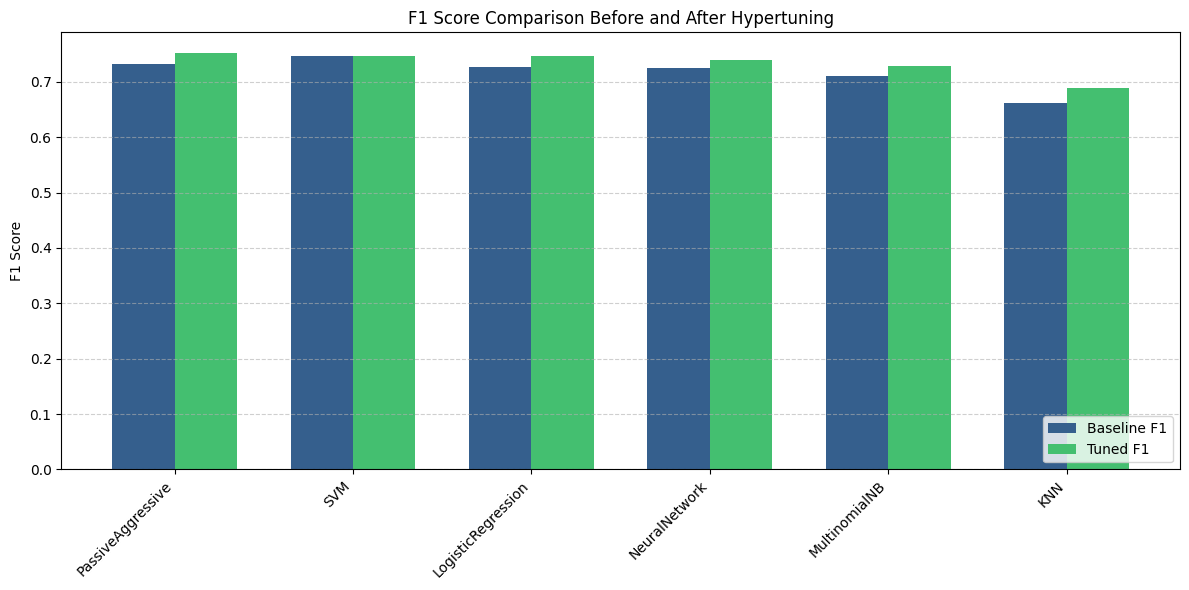

In [ ]:
# Set figure size
plt.figure(figsize=(12, 6))

# Define the models and their F1 scores
models = merged_top_models['Model']
baseline_f1 = merged_top_models['F1 Score_Baseline']
tuned_f1 = merged_top_models['F1 Score_Final']

# Set up the bar positions
x = np.arange(len(models))
width = 0.35  # width of the bars

# 🎨 Viridis colormap and pick blue/green shades
viridis = cm.get_cmap('viridis', 256)
baseline_color = to_hex(viridis(0.3))  # bluish side
tuned_color = to_hex(viridis(0.7))     # greenish side

# Plot bars
plt.bar(x - width/2, baseline_f1, width, label='Baseline F1', color=baseline_color)
plt.bar(x + width/2, tuned_f1, width, label='Tuned F1', color=tuned_color)

# Labels and Title
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Before and After Hypertuning')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("F1_Comparison.png")

# Show plot
plt.show()

---
### 9.5 📋 Greatest F1 Improvement Per Model

---

In [ ]:
# Calculate the F1 Score Improvement
merged_top_models["F1 Score Improvement"] = merged_top_models["F1 Score_Final"] - merged_top_models["F1 Score_Baseline"]

# Sort by F1 Score Improvement
top_improved_models = merged_top_models.sort_values(by="F1 Score Improvement", ascending=False)

# Show the Top 5 Models with Greatest F1 Improvement
top_improved_models[['Model', 'Dataset', 'F1 Score_Baseline', 'F1 Score_Final', 'F1 Score Improvement']].head(5)


,Model,Dataset,F1 Score_Baseline,F1 Score_Final,F1 Score Improvement
5,KNN,dropped_v1_basic_clean,0.662335,0.688376,0.026040
0,PassiveAggressive,kept_v7_lowercase_words_only,0.731405,0.751848,0.020444
2,LogisticRegression,kept_v5_lemma_stem,0.726462,0.746199,0.019737
4,MultinomialNB,prepended_v4_stemmed,0.710336,0.729526,0.019190
3,NeuralNetwork,kept_v4_stemmed,0.724138,0.738595,0.014457


---
### 9.6 Visualize the Greatest F1 Improvement

---

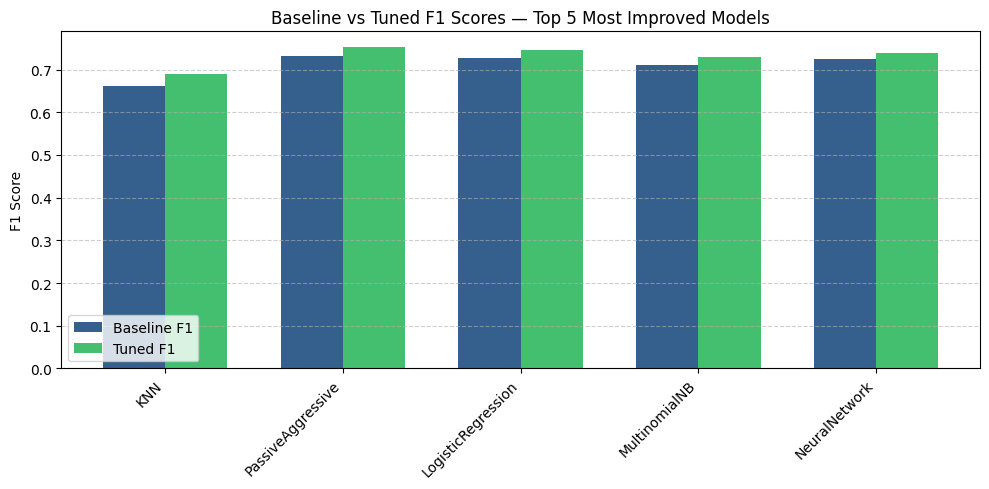

In [ ]:
# 🛠️ Ensure improvements calculated
merged_top_models["F1 Score Improvement"] = merged_top_models["F1 Score_Final"] - merged_top_models["F1 Score_Baseline"]

# 🏆 Select Top 5 Improved Models
top5_improved = merged_top_models.sort_values(by="F1 Score Improvement", ascending=False).head(5)

# 🎨 Viridis colors (consistent blue-green)
viridis = cm.get_cmap('viridis', 256)
baseline_color = to_hex(viridis(0.3))  # bluish
tuned_color = to_hex(viridis(0.7))     # greenish

# 📊 Plot Baseline vs Tuned F1 for Top 5
plt.figure(figsize=(10, 5))

models = top5_improved['Model']
baseline_f1 = top5_improved['F1 Score_Baseline']
tuned_f1 = top5_improved['F1 Score_Final']

x = np.arange(len(models))
width = 0.35

# Bars
plt.bar(x - width/2, baseline_f1, width, label='Baseline F1', color=baseline_color)
plt.bar(x + width/2, tuned_f1, width, label='Tuned F1', color=tuned_color)

# Labels
plt.ylabel('F1 Score')
plt.title('Baseline vs Tuned F1 Scores — Top 5 Most Improved Models')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(loc='lower left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save as SVG
plt.savefig("baseline_vs_tuned_top5_models.png")

# Show
plt.show()


---
### 9.7 🏆 Top Model per Dataset: Baseline vs Tuned Comparison

Identify the top-scoring hypertuned result for each unique dataset:

---

In [ ]:
# Top per unique dataset
merged_top_datasets = merged.drop_duplicates(subset="Dataset", keep="first").reset_index(drop=True)

# Calculate Improvements
for metric in ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]:
    merged_top_datasets[f"{metric} Improvement"] = merged_top_datasets[f"{metric}_Final"] - merged_top_datasets[f"{metric}_Baseline"]

# View
merged_top_datasets.head()


,Dataset,Model,Accuracy_Final,Precision_Final,Recall_Final,F1 Score_Final,ROC AUC_Final,Accuracy_Baseline,Precision_Baseline,Recall_Baseline,F1 Score_Baseline,ROC AUC_Baseline,Accuracy Improvement,Precision Improvement,Recall Improvement,F1 Score Improvement,ROC AUC Improvement
0,kept_v7_lowercase_words_only,PassiveAggressive,0.792575,0.764961,0.739234,0.751848,0.858755,0.774435,0.741022,0.722238,0.731405,0.848198,0.018140,0.023939,0.016996,0.020444,0.010556
1,kept_v2_no_emojis_mentions,PassiveAggressive,0.792575,0.765172,0.738839,0.751749,0.858631,0.775778,0.743031,0.723028,0.732782,0.848302,0.016797,0.022141,0.015811,0.018967,0.010329
2,kept_v9_minimal_processing,PassiveAggressive,0.791765,0.763976,0.738633,0.751029,0.860723,0.784370,0.762423,0.716092,0.738468,0.852644,0.007395,0.001552,0.022541,0.012561,0.008080
3,kept_v1_basic_clean,PassiveAggressive,0.790559,0.762310,0.737258,0.749561,0.859797,0.779474,0.750662,0.721448,0.735599,0.851262,0.011085,0.011648,0.015810,0.013962,0.008536
4,kept_v6_custom_stopwords,PassiveAggressive,0.789281,0.758507,0.741107,0.749353,0.864084,0.779533,0.746268,0.730040,0.737870,0.852462,0.009748,0.012240,0.011067,0.011483,0.011622


---
### 9.8 📊 Visualize F1 Score Comparison per Dataset

---

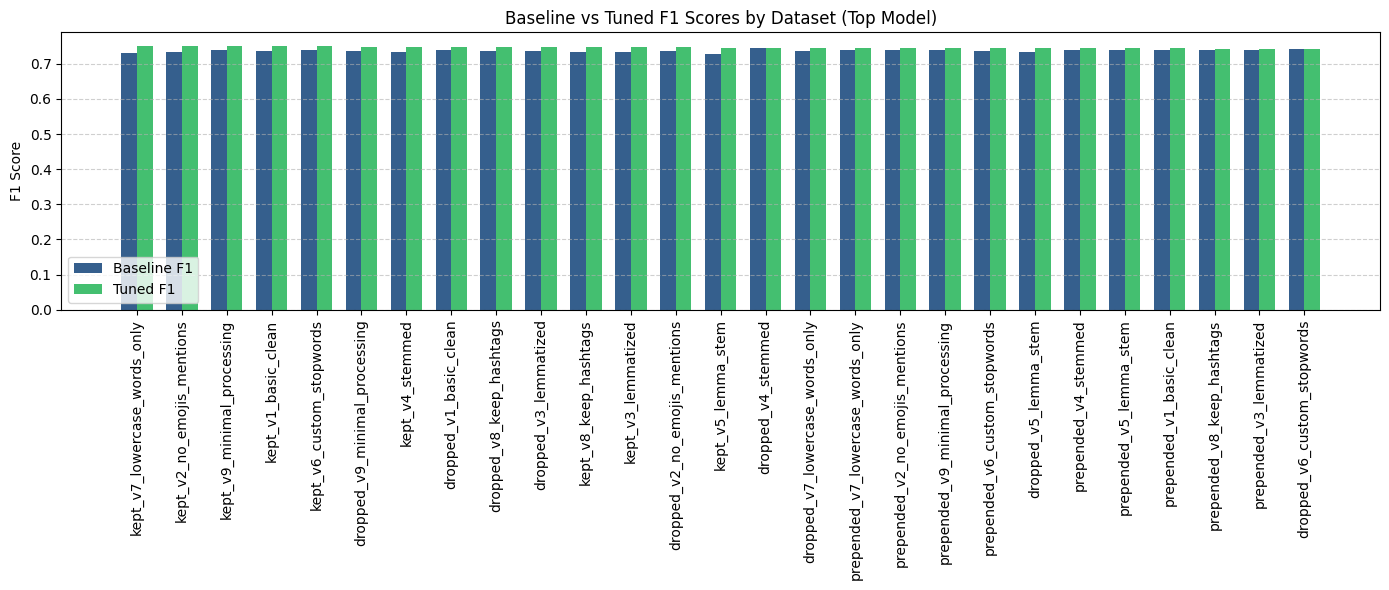

In [ ]:
# Plot
plt.figure(figsize=(14, 6))

datasets = merged_top_datasets['Dataset']
baseline_f1 = merged_top_datasets['F1 Score_Baseline']
tuned_f1 = merged_top_datasets['F1 Score_Final']

x = np.arange(len(datasets))
width = 0.35

plt.bar(x - width/2, baseline_f1, width, label='Baseline F1', color=baseline_color)
plt.bar(x + width/2, tuned_f1, width, label='Tuned F1', color=tuned_color)

plt.ylabel('F1 Score')
plt.title('Baseline vs Tuned F1 Scores by Dataset (Top Model)')
plt.xticks(x, datasets, rotation=90)
plt.legend(loc='lower left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("baseline_vs_tuned_f1_by_dataset.png")
plt.show()



---
### 9.9 Best Hyper-Tuned Model Hyperparameters

---

In [ ]:
filepath = "final_ht_performance_metrics/kept_v7_lowercase_words_only_best_model.txt"

with open(filepath, "r") as f:
    lines = f.readlines()
    for line in lines:
        print(line.strip())

Dataset: kept_v7_lowercase_words_only
Best Model: PassiveAggressive
Best Hyperparameters:
clf__C: 0.01
clf__max_iter: 500
clf__tol: 0.001

Best Metrics:
Accuracy: 0.7926
Precision: 0.7650
Recall: 0.7392
F1 Score: 0.7518
ROC AUC: 0.8588


---
### Visualize Original Baseline Models vs Final Best Models

---

In [ ]:
# 📥 Load attached dataset (Baseline results)
baseline_df = pd.read_csv("Sandbox/initial_model_comparison_results.csv")

# 📋 Merge the two datasets
merged = pd.merge(
    left=top_per_model,
    right=baseline_df,
    on="Model",
    how="inner",
    suffixes=('_Tuned', '_Baseline')
)

# 🛠 Prepare the data for plotting
models = merged['Model']
f1_before = merged['F1 Score_Baseline']
f1_after = merged['F1 Score_Tuned']

# 📊 Set up the figure
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, f1_before, width, label='Before Hypertuning', color='lightblue')
bars2 = ax.bar(x + width/2, f1_after, width, label='After Hypertuning', color='seagreen')

# 📑 Labels, title, and legend
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison Before and After Hypertuning')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=20, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# ✏️ Display values on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

# 💾 Save the figure
output_chart_path = 'f1_score_comparison_chart.png'
plt.tight_layout()
plt.savefig(output_chart_path)
plt.close()

output_chart_path


'f1_score_comparison_chart.png'

---
### 9.10 📊 Visualize Best Model Performance

We visualize the best-tuned model's performance using:

- **Confusion Matrix** — How predictions are distributed across actual classes
- **Learning Curve** — How training/validation scores evolve with dataset size
- **ROC Curve** — Model's discrimination capability between classes

These visualizations help interpret not just the final score, but the model’s learning behavior and potential overfitting/underfitting.

#### 📂 Visualizations for: `kept_v7_lowercase_words_only` + `PassiveAggressive`

- 🧩 [Confusion Matrix](./final_ht_performance_metrics/kept_v7_lowercase_words_only_PassiveAggressive/confusion_matrix.png)
- 📈 [Learning Curve](./final_ht_performance_metrics/kept_v7_lowercase_words_only_PassiveAggressive/learning_curve.png)
- 🧪 [ROC Curve](./final_ht_performance_metrics/kept_v7_lowercase_words_only_PassiveAggressive/roc_curve.png)

---


🧩 Confusion Matrix


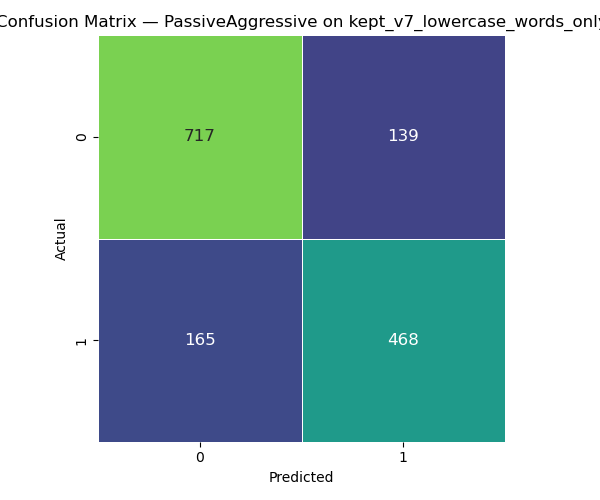


📈 Learning Curve


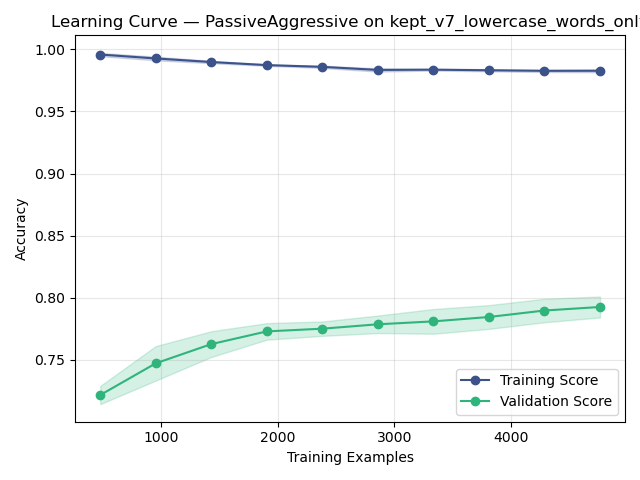


🧪 ROC Curve


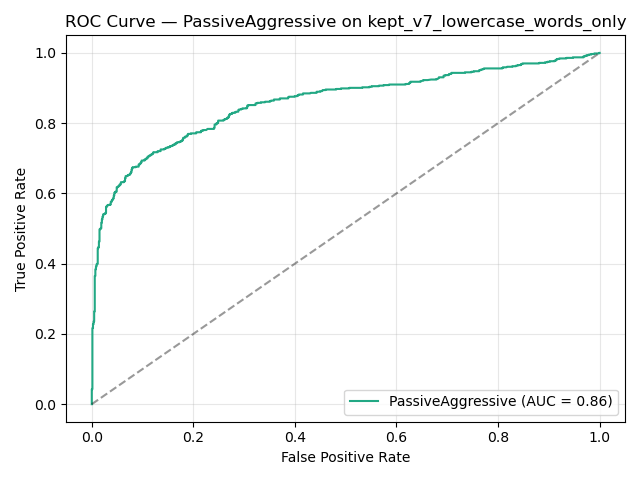

In [ ]:
# 📸 Display model performance visualizations inline

# Paths to the saved plots
conf_matrix_path = "final_ht_performance_metrics/kept_v7_lowercase_words_only_PassiveAggressive/confusion_matrix.png"
learning_curve_path = "final_ht_performance_metrics/kept_v7_lowercase_words_only_PassiveAggressive/learning_curve.png"
roc_curve_path = "final_ht_performance_metrics/kept_v7_lowercase_words_only_PassiveAggressive/roc_curve.png"

# Display them
print("🧩 Confusion Matrix")
display(Image(filename=conf_matrix_path))

print("\n📈 Learning Curve")
display(Image(filename=learning_curve_path))

print("\n🧪 ROC Curve")
display(Image(filename=roc_curve_path))


---
### 10. ✅ Research Paper <a name="conclusion"></a>

---
[📄 View Research Paper (PDF)](Deliverables/CSC-4260-NLP%20Tweets.pdf)
